#  Zaful Classification Project

## Objective: Predict what factors influence a clothing item to be ranked higher

### Dataframes

#### Items:

`Rank` - order in which items are listed

`SKU` - stock keeping unit

`Item Name` - name of article of clothing

`Recommended Retail Price` - RRP

`Deals` - Viewable deal on item

`Available Colors` - list of colors item comes in including color on mainpage

`Number of Reviews` - number of customer reviews given

`True Fit Percentage` - percent of customers who say the item was true to size

`Too Small Percentage` - percent of customers who say the item was too small

`Too Large Percentage` - percent of customers who say the item was too large

`Review` - information of all ratings for product; each review includes rating given, number of pictures taken in review, comments, color/size the consumer bought, and overall fit of product

####  Reviews:

`SKU` - stock keeping unit

`Individual Rating` - Rating given out of 5 stars

`Number of Pictures` - Number of pictures taken in review

`Comment` - Comment

`Color/Size` - Color and size of clothing reviewed

`Overall Fit` - True to size

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import csv
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
import random

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn import tree

import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.cluster import KMeans
import itertools

from collections import Iterable

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import pandas as pd
import string
import seaborn as sns
from wordcloud import WordCloud

from nltk.collocations import *
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

import random

import statsmodels.api as sm

from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, f1_score,precision_recall_curve,precision_score, accuracy_score

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import silhouette_score
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#Import svm model
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier

# numerical_reviews = ['Individual Rating', 'Number of Pictures', 'Height', 'Waist', 'Hips', 'Date (ordinal)', 'Time (numerical)']
cmap = sns.diverging_palette(220, 10, as_cmap=True)

from sklearn.model_selection import GridSearchCV


<ipython-input-1-d2875e69b4d8>:34: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# Setup
item_csv = r"zaful_floral_dresses_latest.csv"
items = pd.read_csv(item_csv)

reviews_csv = r"zaful_reviews_latest.csv"
reviews = pd.read_csv(reviews_csv)

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
items.head()

### Split dataset into testing and training set

In [ ]:
# # 70% training, 30% testing
# num_dresses = len(items)
# sample_size = np.arange(1, num_dresses)

# X = items.iloc[:,1:]
# y = items.iloc[:,0:2]

# # X_items_train, X_items_test, y_items_train, y_items_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_items = X
reviews = pd.merge(reviews, items[['SKU','Rank']], how='inner', on=['SKU'])
# X_reviews = pd.merge(X_reviews, y, how='inner', on=['SKU'])# add ranking column
# # X_reviews_test = pd.merge(reviews, X_items_test, how='inner', on=['SKU']).iloc[:,0:11]

In [ ]:
reviews.columns

### Check to make sure we have all products in both tables

In [ ]:
reviews['SKU'].nunique()

In [ ]:
items['SKU'].nunique()

In [ ]:
len(items[items['Number of Reviews'].isnull()])

In [ ]:
# Get relevant rows
# reviews = reviews #.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,-1]]

reviews.head(1)

# Phase 2: Cleaning the Data



## Reviews Table

### Fix `Height`, `Waist`, `Hips`, `Bust`', and `Overall Fit` values and strip unnecessary text

In [ ]:
reviews_cleaned = reviews.copy()

def clean_reviews_whhof(df):
    # Fill empty values with np.NaN
    df = df.replace('[]', ' ')
    # Rename rows - measured in cm (height, waist, hips)
    df = df.rename(columns = {'Unnamed: 7': 'Height', 'Unnamed: 8': 'Waist', 'Unnamed: 9': 'Hips', 'Unnamed: 10': 'Bust'}, inplace = False)

    # replace nan with NaN
    df = df.replace('nan',np.NaN)

    # Reorganize hips, waist, overall fit, height, bust columns
    for record in range(0,len(df)):
        # Bust is in height, rest are missing
        if df.iloc[record,6:11].isnull().sum() == 3 and not df['Height'].str.contains("Height").fillna(False)[record] :
            df.iloc[record, 7] = df.iloc[record, 6] 
            df.iloc[record, 6] = np.NaN 
        # Bust is in waist
        if df.iloc[record,6:11].isnull().sum() == 2 and df['Waist'].str.contains("Height").fillna(False)[record]:
            bust = df.iloc[record, 8] 
            df.iloc[record, 10] = bust
            df.iloc[record, 8] = np.NaN
        if df.iloc[record,6:11].isnull().sum() == 1:
            # Overall Fit missing
            if not df['Overall Fit'].str.contains("Overall Fit").fillna(False)[record]:
                df.iloc[record, 10] = df.iloc[record, 9] 
                df.iloc[record, 9] = df.iloc[record, 8]
                df.iloc[record, 8] = df.iloc[record, 7]
                df.iloc[record, 7] = df.iloc[record, 6]
                df.iloc[record, 6] = np.NaN
            # Height missing
            elif not df['Height'].str.contains("Height").fillna(False)[record]:
                df.iloc[record, 10] = df.iloc[record, 9] 
                df.iloc[record, 9] = df.iloc[record, 8]
                df.iloc[record, 8] = df.iloc[record, 7]
                df.iloc[record, 7] = np.NaN
            # Waist missing
            elif not df['Waist'].str.contains("Waist").fillna(False)[record]:
                df.iloc[record, 10] = df.iloc[record, 9] 
                df.iloc[record, 9] = df.iloc[record, 8]
                df.iloc[record, 8] = np.NaN 
            # Bust missing
            elif not df['Bust'].str.contains("Bust").fillna(False)[record]:
                df.iloc[record, 9] = df.iloc[record, 10] 
                df.iloc[record, 10] = np.NaN 
            # Hips missing
            else:
                bust = df.iloc[record, 9] 
                df.iloc[record, 10] = bust
                df.iloc[record, 9] = np.NaN

    # Extract only the numbers in centimeters
    df['Height'] = df['Height'].str.extract(r'(?<!\d)(\d{3})(?!\d)', expand=False)   
    df['Waist'] = df['Waist'].str.extract(r'(?<!\d)(\d{2})(?!\d)', expand=False)  
    df['Hips'] = df['Hips'].str.extract(r'(?<!\d)(\d{2})(?!\d)', expand=False)  
    df['Bust'] = df['Bust'].str.extract(r'(\d{2}[a-zA-Z]+)', expand=False)
    
    # Convert bust sizes to cm
    bust_conversion = {"34C": 92.5,
    "32C": 87.5,
    "34D": 95.5,
    "32D": 90,
    "34B": 90,
    "32B": 85,
    "36C": 98,
    "32AA": 76,
    "36AA": 86,
    "32A": 82.5,
    "34AA": 81,
    "36D": 101,
    "38AA": 81.5,
    "34A": 87.5,
    "36B": 95.5,
    "38C": 103,
    "36A": 92.5,
    "38B": 100.5,
    "38A": 98,
    "38D": 105.5}
    df['Bust'] = df['Bust'].replace(bust_conversion)

    # Replace Overall Fit 
    # 0 - True to Size
    # 1 - Large
    # -1 - Small
    df['Overall Fit'] = df['Overall Fit'].str.extract(r':(.*)<', expand=False).str.strip().replace({'True to Size', 'Small', 'Large'}, {0, -1, 1})
    
    return df

### Split `Color/Size` column into 'Color' and 'Size' columns

In [ ]:
# Separate color and size bought by customer into two columns

def reviews_clean_color_size(df):
    df['Color'] = df['Color/Size'].str.extract(r':(.*)/', expand=False)
    df['Size'] = df['Color/Size'].str.extract(r'Size:(.*)', expand=False)
    return df

### Add and delete columns: Split `Date Stamp` column into `Date`, `Time`, `Time (numerical)`, and `Date (ordinal)`; add `Total Colors` and `Comment Length` column

In [ ]:
def reviews_clean_date_time_color_size_comment(df):

    # Separate time and date for linear regression purposes
    df['Date (ordinal)'] = pd.to_datetime(reviews_cleaned['Date Stamp'].str.extract(r'(.*) at', expand=False)).map(dt.datetime.toordinal)
    df['Date'] = pd.to_datetime(reviews_cleaned['Date Stamp'].str.extract(r'(.*) at', expand=False))
    df['Time'] = df['Date Stamp'].str.extract(r'at (.*) [a-zA-Z]+', expand=False)

    result = []
    for i in reviews_cleaned['Time']: 
        (h, m, s) = i.split(':')
        result.append(int(h) * 3600 + int(m) * 60 + int(s))

    df['Time (numerical)']  = result

    # Delete columns that are no longer needed
    df = df.drop(columns=['Color/Size', 'Date Stamp'])

    # Number of total colors (including main)
    # reviews_cleaned['Total Colors'] = reviews_color_encode.apply(lambda x: len(x))

    # Comment Length
    df['Comment'] = df.Comment.astype(str)
    df['Comment Length'] = df['Comment'].apply(lambda x: len(x))

    # change str type to int 
    df[["Height", "Waist",'Hips', 'Bust']] = df[["Height", "Waist",'Hips', 'Bust']].apply(pd.to_numeric)
    
    # drop duplicates
    df = df.drop_duplicates()
    df = df.reset_index()
    
    return df

### Clean `Reviews` table

In [ ]:
reviews_cleaned = clean_reviews_whhof(reviews_cleaned)

In [ ]:
reviews_cleaned = reviews_clean_color_size(reviews_cleaned)

In [ ]:
reviews_cleaned = reviews_clean_date_time_color_size_comment(reviews_cleaned)

In [ ]:
reviews_cleaned = reviews_cleaned.drop('index', axis=1)

In [ ]:
reviews_cleaned.head(1)

In [ ]:
reviews_cleaned.describe()

### Observations

We see that the individual ratings are highly skewed and the majority of number of pictures posted is 0. Also, the overall fit leans towards true to size. The height, waist, and hips seem very skewed; maybe there are false reviews or default options were filled in. The ranks column seems skewed right so the majority of comments are coming from higher ranked clothing items. The date and time seem very spread out and the comment length trails off the longer the comment is.

In [ ]:
reviews_cleaned.corr()

In [ ]:
# numerical_reviews = ['Individual Rating', 'Number of Pictures', 'Height', 'Waist', 'Hips', 'Date (ordinal)', 'Time (numerical)']
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(reviews_cleaned.corr(), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Observations

SKU and date are moderately positively correlated probably because recent dates have a higher SKU. The number of pictures seems to have a positive correlation between height and waist so people with a bigger size post more pictures. Individual rating and overall fit have a negative correlation so the higher the rating, the smaller the fit. Waist and height have the highest correlation. Date and rank have a negative correlation with each other so reviews that date further back have a lower ranking (number gets bigger the lower the ranking). Comment length and number of pictures seems to have a stronger positive correlation with each other so the more the pictures, the longer the comment.

### Rank Observations: 
Rank seems to have a negative relationship with almost every feature so that means reviews with higher ratings, pictures, height, waist, hips, date, and comment length have a better ranking (number gets smaller).

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

## Figure out what to do with missing values

In [ ]:
# Check missing values

for i in range(1,11):
    if i != 3:
        print(reviews_cleaned.columns[i])
        print(reviews_cleaned.iloc[:,i].value_counts())
        print(reviews_cleaned.iloc[:,i].isna().sum(), " missing values")
        print()


In [ ]:
for i in range(0, len(reviews_cleaned.columns)):
    print("%s: %d missing values" % (reviews_cleaned.columns[i],reviews_cleaned.iloc[:,i].isna().sum()))
    
print(len(reviews_cleaned), " total reviews")

## Figuring out what to do with spam reviews

In [ ]:
comments_list = reviews_cleaned.iloc[:,3].value_counts()
nonunique_comments_list = comments_list[comments_list > 1] # non-unique
print(nonunique_comments_list)
print(nonunique_comments_list.values.sum(), " non-unique comments")

In [ ]:
# 1 means there's only one copy of that comment; >1 number of non-unique comments
comments_list.groupby(np.where(comments_list.values > 1, '>1', comments_list.values)).sum()

### Add `non-unique` column that labels non-unique comments as 1, 0 otherwise

In [ ]:
# Split comments into spam and nonspam depending on whether comment has been repeated or is unique
# 441 non-unique categories, 3

reviews_cleaned['non_unique'] = [1 if i in nonunique_comments_list else 0 for i in reviews_cleaned.iloc[:,3]]

In [ ]:
# from nltk.tokenize import sent_tokenize, word_tokenize

# comment_tokenize = reviews_cleaned[['Comment']]
# #ex = 'Hello Mr. Smith, how are you today? I am doing well; thank you.'
# # sent_tokenize(ex)
# comment_tokenize['tokenized comment'] = comment_tokenize['Comment'].apply(word_tokenize)
# #sent_tokenize(comment_tokenize.values)

### Add `in_bigram` column that labels comments with frequent phrases as 1, 0 otherwise

In [ ]:
# find most common words in spam list
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
pairs = nltk.bigrams(reviews_cleaned[reviews_cleaned['non_unique'] == 0]['Comment'])
# change this to read in your data
finder = nltk.collocations.BigramCollocationFinder.from_words(reviews_cleaned[reviews_cleaned['non_unique'] == 1]['Comment'])

# only bigrams that appear 3+ times
finder.apply_freq_filter(2)

# return the 10 n-grams with the highest PMI
# finder.nbest(bigram_measures.pmi,200)

In [ ]:
def Extract(lst):
    return [item[0] for item in lst]

bigram_phrases = Extract(finder.nbest(bigram_measures.pmi,200))
len(bigram_phrases)

In [ ]:
reviews_cleaned['in_bigram'] = [0] * len(reviews_cleaned)

for j in bigram_phrases:
    for i in range(len(reviews_cleaned)):
        if j in reviews_cleaned.loc[i, 'Comment']:
            reviews_cleaned.loc[i, 'in_bigram'] = 1
            continue
# reviews_cleaned['in_bigram'] = [1 if any(j in i) for j in bigram_phrases for i in reviews_cleaned['Comment']]


In [ ]:
# check if any spam comments don't have bigram phrase

len(reviews_cleaned[reviews_cleaned['non_unique'] != reviews_cleaned['in_bigram']])

In [ ]:
# check if any nonspam comments are in bigram phrase

len(reviews_cleaned[(reviews_cleaned['non_unique'] == 0) & (reviews_cleaned['in_bigram'] == 1)])

In [ ]:
len(reviews_cleaned[(reviews_cleaned['non_unique'] == 1) & (reviews_cleaned['in_bigram'] == 0)])

In [ ]:
reviews_cleaned[(reviews_cleaned['non_unique'] == 1) & (reviews_cleaned['Number of Pictures'] != 0)].head(50)

### Add `spam` column that denotes labels review as spam if non-unique = 1 or in_bigram = 1, 0 otherwise

In [ ]:
reviews_cleaned['spam'] = [1 if (reviews_cleaned.loc[i,'non_unique'] == 1 or reviews_cleaned.loc[i,'in_bigram'] == 1) else 0 for i in range(len(reviews_cleaned))]

In [ ]:
reviews_cleaned.head(1)

### Average counts for spam and non-spam

In [ ]:
spam_avg = pd.pivot_table(reviews_cleaned,index=["spam"])
spam_avg

Spam emails have a lower average comment length than non-spam. Suprisingly, the mean dates are very similar. The individual ratings for spam are a little higher and the mean number of pictures for spam are a little lower. The ranks are very similar

In [ ]:
for i in spam_avg.columns:
    not_spam = reviews_cleaned[reviews_cleaned['spam'] == 0][i]
    spam = reviews_cleaned[reviews_cleaned['spam'] == 1][i]
    sns.distplot(not_spam, kde=False)
    sns.distplot(spam, kde=False)
    plt.ylabel('Count')
    plt.legend(labels=['not spam', 'spam'])
    
    plt.show()

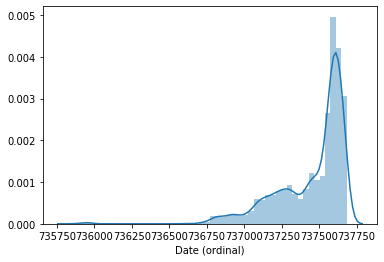

In [10]:
sns.distplot(reviews_cleaned.loc[:,'Date (ordinal)'])

Insert observations

### Figuring out why there are so many outliers in height and seeing if there is a correlation between height and spam

In [ ]:
# Looking at reviews with height < 140 which should be spam
# I suspect that they were either not given the option to input height/waist (very small numbers) nor hips/bust (NaN) and/or were assigned after reviewing

reviews_cleaned[(reviews_cleaned['Height'] < 140) & (reviews_cleaned['spam'] == 0)].tail(50)

no . Therefore, want to classify spam comments only through comments and no other features.

In [ ]:
reviews_cleaned[(reviews_cleaned['Individual Rating'] < 4)]

### Dealing with missing data

Is data missing completely at random? No, because...

## Items Table

In [ ]:
items.head()

In [ ]:
num_dresses = len(items)

### Separate `Item Name` column into three columns and format percentages to floats

In [ ]:
# Make copy of items into new items_cleaned table
items_cleaned = items.copy()

def clean_items(df):

    # Separate Item Name column into three columns: Item Name, Color 0, and Size 0 
    df['Color 0'] = df['Item Name'].str.extract(r'- (.*) [a-zA-Z ]+', expand=False) 
    df['Size 0'] = df['Item Name'].str.extract(r'- [a-zA-Z- ]+ (.*)', expand=False) 
    df['Item Name'] = df['Item Name'].str.extract(r'(.*) -', expand=False) 

    # Change type for percentages to floats 
    df['True Fit Percentage'] = df['True Fit Percentage'].str.extract(r'(\d+\.\d+)', expand=False).astype(float) 
    df['Too Small Percentage'] = df['Too Small Percentage'].str.extract(r'(\d+\.\d+)', expand=False).astype(float) 
    df['Too Large Percentage'] = df['Too Large Percentage'].str.extract(r'(\d+\.\d+)', expand=False).astype(float) 
    
    df['Available Colors'] = df['Available Colors'].str.extract(r'\;(.*)')
    df['Available Colors'] = df['Available Colors']
    # df['Available Colors'] = df['Color 0'] + '; ' + df['Available Colors']

    # replace NaN values in 'Number of Reviews' to 0
    df['Number of Reviews'] = df['Number of Reviews'].replace({np.NaN : 0})
    
    # item name length
    df['Item Name Length'] = df['Item Name'].str.split().str.len()
    
    # Rank variable
    df = df.reset_index()
    df['Rank'] = df['index'] + 1
    df = df.drop('index', axis=1)
    
    # divide ranks into three 'scroll' categories
    df['scroll'] = [5] * len(df)

    for i in range(0, len(df)):
        if df.loc[i, 'Rank'] < (num_dresses / 5):
            df.loc[i, 'scroll'] = 1
        elif df.loc[i, 'Rank'] < (num_dresses * 2 / 5):
            df.loc[i, 'scroll'] = 2
        elif df.loc[i, 'Rank'] < (num_dresses * 3 / 5):
            df.loc[i, 'scroll'] = 3
        elif df.loc[i, 'Rank'] < (num_dresses * 4 / 5):
            df.loc[i, 'scroll'] = 4

        
     # divide ranks into three 'scroll' categories
    df['page'] = [5] * len(df)

    for i in range(0, len(df)):
        if df.loc[i, 'Rank'] < 120:
            df.loc[i, 'page'] = 1
        elif df.loc[i, 'Rank'] < 240:
            df.loc[i, 'page'] = 2
        elif df.loc[i, 'Rank'] < 360:
            df.loc[i, 'page'] = 3
        elif df.loc[i, 'Rank'] < 480:
            df.loc[i, 'page'] = 4

            
    # divide ranks into three 'scroll' categories
    df['SKU group'] = [3] * len(df)

    for i in range(0, len(df)):
        if df.loc[i, 'SKU'] < 300000000:
            df.loc[i, 'SKU group'] = 1
        elif df.loc[i, 'SKU'] < 430000000:
            df.loc[i, 'SKU group'] = 2

    # number of available colors (includes primary color)
    df['Number of Available Colors'] = [1] * len(df)

    for i in range(0, len(df)):
        if isinstance(df.loc[i, 'Available Colors'], str):
            df.loc[i, 'Number of Available Colors'] = df.loc[i,'Available Colors'].count(';') + 2
            
    # Add price difference column between RRP and Shop Price
    df['price_diff'] = df['Recommended Retail Price'].sub(df['Shop Price'], axis = 0) 
    # Create column that distinguishes RRPs less than $40, those usually don't appear in the beginning ranks
    df['rrp<40'] = [1 if i < 40 else 0 for i in df['Recommended Retail Price']]
    
    #df = pd.get_dummies(df,columns=['Size 0'], prefix='size',drop_first=True)

    return df

In [ ]:
items_cleaned = clean_items(items_cleaned)
items_cleaned.head(10)

In [ ]:
items_cleaned[items_cleaned['Size 0'] == '3xl']

In [ ]:
pd.options.display.max_colwidth = 300

Fix issues

In [ ]:
issue_rank = items_cleaned[items_cleaned['Size 0'].str.contains('Purple')]['Rank'].values[0]

In [ ]:
items_cleaned[items_cleaned['Size 0'].str.contains('Purple')]

In [ ]:
# Solve problems
items_cleaned.iloc[issue_rank, items_cleaned.columns.get_loc('Color 0')] = 'Light Purple'
items_cleaned.iloc[issue_rank, items_cleaned.columns.get_loc('Size 0')] =  'None'
# items_cleaned[items_cleaned['Size 0'].str.contains('Purple')]['Size 0'] = np.NaN

In [ ]:
cols = [3,4,5,6,7,8,9,10,11,12,13,14]

for i in cols:  
    print(items_cleaned.columns[i])
    print(items_cleaned.iloc[:,i].value_counts())
    print(items_cleaned.iloc[:,i].isna().sum(), " missing values")
    print()

In [ ]:
items_cleaned[items_cleaned.isnull().any(axis=1)].head()

# missing values only pertain to items with 0 reviews

# Phase 3: Exploratory Data Analysis

In [ ]:
items_cleaned.head(1)

## Reviews

In [3]:
reviews_cleaned['Rank'].values

array([ 1,  1,  1, ..., 39, 39, 39])

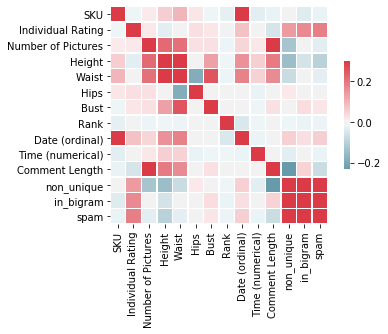

In [4]:
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(reviews_cleaned.corr(), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [5]:
reviews_cleaned.corr()

SKU  Individual Rating  Number of Pictures    Height  \
SKU                 1.000000          -0.010617            0.012518  0.059401   
Individual Rating  -0.010617           1.000000            0.016097 -0.029424   
Number of Pictures  0.012518           0.016097            1.000000  0.224006   
Height              0.059401          -0.029424            0.224006  1.000000   
Waist               0.096353          -0.001982            0.208548  0.652196   
Hips                0.019697           0.032201            0.031021  0.010617   
Bust               -0.010827           0.018649            0.030424  0.132912   
Rank               -0.024508          -0.001605           -0.016512 -0.013396   
Date (ordinal)      0.619777           0.077874            0.044066  0.154629   
Time (numerical)   -0.031199           0.002763            0.017845  0.058167   
Comment Length     -0.020487          -0.051317            0.303684  0.191809   
non_unique          0.003083           0.139607           -0.127835 -0.144321   
in_bigram          -0.037570           0.169860            0.011678 -0.056505   
spam               -0.019393           0.187322           -0.033042 -0.098601   

                       Waist      Hips      Bust      Rank  Date (ordinal)  \
SKU                 0.096353  0.019697 -0.010827 -0.024508        0.619777   
Individual Rating  -0.001982  0.032201  0.018649 -0.001605        0.077874   
Number of Pictures  0.208548  0.031021  0.030424 -0.016512        0.044066   
Height              0.652196  0.010617  0.132912 -0.013396        0.154629   
Waist               1.000000 -0.183774  0.254983 -0.015575        0.181484   
Hips               -0.183774  1.000000 -0.004717 -0.005613        0.003930   
Bust                0.254983 -0.004717  1.000000 -0.005440        0.008110   
Rank               -0.015575 -0.005613 -0.005440  1.000000       -0.044335   
Date (ordinal)      0.181484  0.003930  0.008110 -0.044335        1.000000   
Time (numerical)    0.052774 -0.020855 -0.013813 -0.013345       -0.018535   
Comment Length      0.168580 -0.009552  0.029581 -0.009674        0.011757   
non_unique         -0.074141  0.015346 -0.009123 -0.010941        0.054183   
in_bigram           0.000729  0.009655  0.035099 -0.018936        0.033085   
spam               -0.026914  0.001842  0.019297 -0.016315        0.056301   

                    Time (numerical)  Comment Length  non_unique  in_bigram  \
SKU                        -0.031199       -0.020487    0.003083  -0.037570   
Individual Rating           0.002763       -0.051317    0.139607   0.169860   
Number of Pictures          0.017845        0.303684   -0.127835   0.011678   
Height                      0.058167        0.191809   -0.144321  -0.056505   
Waist                       0.052774        0.168580   -0.074141   0.000729   
Hips                       -0.020855       -0.009552    0.015346   0.009655   
Bust                       -0.013813        0.029581   -0.009123   0.035099   
Rank                       -0.013345       -0.009674   -0.010941  -0.018936   
Date (ordinal)             -0.018535        0.011757    0.054183   0.033085   
Time (numerical)            1.000000        0.011212   -0.030833  -0.009832   
Comment Length              0.011212        1.000000   -0.233645   0.051558   
non_unique                 -0.030833       -0.233645    1.000000   0.419637   
in_bigram                  -0.009832        0.051558    0.419637   1.000000   
spam                       -0.017767       -0.072732    0.637958   0.855698   

                        spam  
SKU                -0.019393  
Individual Rating   0.187322  
Number of Pictures -0.033042  
Height             -0.098601  
Waist              -0.026914  
Hips                0.001842  
Bust                0.019297  
Rank               -0.016315  
Date (ordinal)      0.056301  
Time (numerical)   -0.017767  
Comment Length     -0.072732  
non_unique          0.637958  
in_bigram           0.855698  
spam              

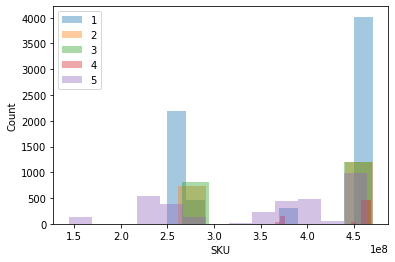

In [27]:
reviews_scroll = pd.merge(reviews_cleaned,spam_percent[['SKU','scroll']], on='SKU')
pg1 = reviews_scroll[reviews_scroll['scroll'] == 1]['SKU']
pg2 = reviews_scroll[reviews_scroll['scroll'] == 2]['SKU']
pg3 = reviews_scroll[reviews_scroll['scroll'] == 3]['SKU']
pg4 = reviews_scroll[reviews_scroll['scroll'] == 4]['SKU']
pg5 = reviews_scroll[reviews_scroll['scroll'] == 5]['SKU']
sns.distplot(pg1, kde=False)
sns.distplot(pg2, kde=False)
sns.distplot(pg3, kde=False)
sns.distplot(pg4, kde=False)
sns.distplot(pg5, kde=False)
plt.ylabel('Count')
plt.legend(labels=['1', '2','3','4','5'])

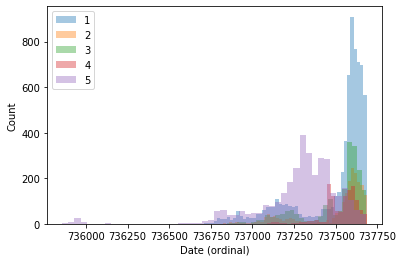

In [21]:
reviews_scroll = pd.merge(reviews_cleaned,spam_percent[['SKU','scroll']], on='SKU')
pg1 = reviews_scroll[reviews_scroll['scroll'] == 1]['SKU']
pg2 = reviews_scroll[reviews_scroll['scroll'] == 2]['SKU']
pg3 = reviews_scroll[reviews_scroll['scroll'] == 3]['SKU']
pg4 = reviews_scroll[reviews_scroll['scroll'] == 4]['SKU']
pg5 = reviews_scroll[reviews_scroll['scroll'] == 5]['SKU']
sns.distplot(pg1, kde=False)
sns.distplot(pg2, kde=False)
sns.distplot(pg3, kde=False)
sns.distplot(pg4, kde=False)
sns.distplot(pg5, kde=False)
plt.ylabel('Count')
plt.legend(labels=['1', '2','3','4','5'])
pg1 = reviews_scroll[reviews_scroll['scroll'] == 1]['Date (ordinal)']
pg2 = reviews_scroll[reviews_scroll['scroll'] == 2]['Date (ordinal)']
pg3 = reviews_scroll[reviews_scroll['scroll'] == 3]['Date (ordinal)']
pg4 = reviews_scroll[reviews_scroll['scroll'] == 4]['Date (ordinal)']
pg5 = reviews_scroll[reviews_scroll['scroll'] == 5]['Date (ordinal)']
sns.distplot(pg1, kde=False)
sns.distplot(pg2, kde=False)
sns.distplot(pg3, kde=False)
sns.distplot(pg4, kde=False)
sns.distplot(pg5, kde=False)
plt.ylabel('Count')
plt.legend(labels=['1', '2','3','4','5'])
sns.distplot(pg2, kde=False)
sns.distplot(pg3, kde=False)
plt.legend(labels=['2','3'])
sns.distplot(pg4, kde=False)
sns.distplot(pg5, kde=False)
plt.legend(labels=['4','5'])

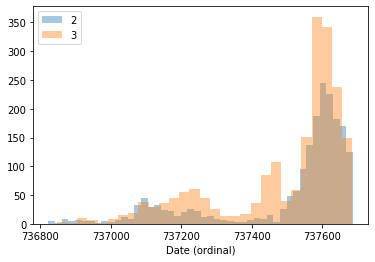

In [25]:
sns.distplot(pg2, kde=False)
sns.distplot(pg3, kde=False)
plt.legend(labels=['2','3'])

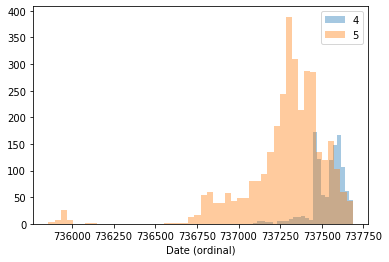

In [26]:
sns.distplot(pg4, kde=False)
sns.distplot(pg5, kde=False)
plt.legend(labels=['4','5'])

## Rank Plots

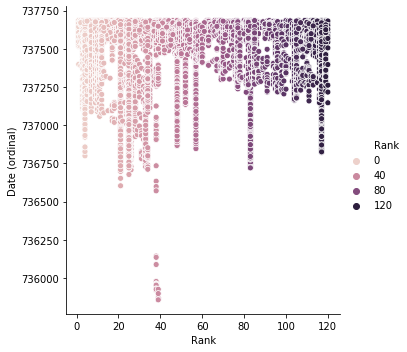

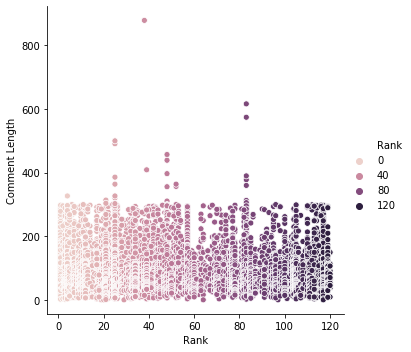

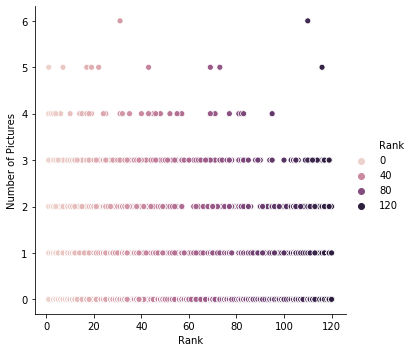

In [6]:
sku_plts = ['Date (ordinal)','Comment Length','Number of Pictures']
for i in sku_plts:
    sns.relplot(x='Rank', y=i,hue='Rank', data=reviews_cleaned)
    plt.show()

# Create 'spam_percent' table 

In [ ]:
reviews_cleaned.describe()

In [ ]:
sku_spam = reviews_cleaned.groupby(['SKU']).sum()[['spam']] # number of spam
sku_count = reviews_cleaned.groupby(['SKU']).count()[['Rank']] # number of items
sku_date = reviews_cleaned.groupby(['SKU']).median()[['Date (ordinal)']] # median date
sku_time = reviews_cleaned.groupby(['SKU']).median()[['Time (numerical)']] # median time
sku_comlen = reviews_cleaned.groupby(['SKU']).median()[['Comment Length']] # median comment length
sku_pics_count = reviews_cleaned.groupby(['SKU']).sum()[['Number of Pictures']] # number of pictures
sku_pics_med = reviews_cleaned.groupby(['SKU']).median()[['Number of Pictures']] # median number of pictures

spam_percent = pd.DataFrame()
spam_percent = pd.merge(sku_spam,sku_count, on='SKU')
spam_percent = pd.merge(spam_percent, sku_date, on='SKU')
spam_percent = pd.merge(spam_percent, sku_time, on='SKU')
spam_percent = pd.merge(spam_percent, sku_comlen, on='SKU')
spam_percent = pd.merge(spam_percent, sku_pics_med, on ='SKU')
spam_percent = pd.merge(spam_percent, sku_pics_count, on ='SKU')

spam_percent = spam_percent.rename({'Comment Length': 'Median Comment Length','Rank': 'Number of Comments', 'Date (ordinal)' : 'Median Comment Date', 'Number of Pictures_x' : 'Median Number of Pictures', 'Number of Pictures_y' : 'Total Pictures'}, axis='columns')

spam_percent['Spam Percent'] = spam_percent['spam'] / spam_percent['Number of Comments']
spam_percent = pd.merge(spam_percent, items_cleaned[['Rank','SKU','scroll','page']], on='SKU')

In [ ]:
sku_mean_date = reviews_cleaned.groupby(['SKU']).mean()[['Date (ordinal)']]
spam_percent = pd.merge(spam_percent, sku_mean_date, on ='SKU')
spam_percent = spam_percent.rename({'Date (ordinal)': 'Mean Comment Date'},axis='columns')

sku_25_date = reviews_cleaned.groupby(['SKU']).quantile(.25)[['Date (ordinal)']] 
spam_percent = pd.merge(spam_percent, sku_25_date, on ='SKU')
spam_percent = spam_percent.rename({'Date (ordinal)': '25th Comment Date'},axis='columns')

sku_75_date = reviews_cleaned.groupby(['SKU']).quantile(.75)[['Date (ordinal)']] 
spam_percent = pd.merge(spam_percent, sku_75_date, on ='SKU')
spam_percent = spam_percent.rename({'Date (ordinal)': '75th Comment Date'},axis='columns')

sku_min_date = reviews_cleaned.groupby(['SKU']).quantile(0)[['Date (ordinal)']] 
spam_percent = pd.merge(spam_percent, sku_min_date, on ='SKU')
spam_percent = spam_percent.rename({'Date (ordinal)': 'Min Comment Date'},axis='columns')

sku_max_date = reviews_cleaned.groupby(['SKU']).quantile(1)[['Date (ordinal)']] 
spam_percent = pd.merge(spam_percent, sku_max_date, on ='SKU')
spam_percent = spam_percent.rename({'Date (ordinal)': 'Max Comment Date'},axis='columns')

spam_percent['Range Date'] = spam_percent['Max Comment Date'] - spam_percent['Min Comment Date']
spam_percent['IQR Date'] = spam_percent['75th Comment Date'] - spam_percent['25th Comment Date']

In [ ]:
spam_percent.head()

In [ ]:
spam_percent.corr()

# SAVE FILES

In [ ]:
#items_cleaned.to_csv (r'items_cleaned_2.csv', index=False)
#reviews_cleaned.to_csv (r'reviews_cleaned_2.csv', index=False)
#spam_percent.to_csv (r'spam_percent_2.csv', index=False)

spam_percent = pd.read_csv(r'spam_percent_2.csv')
items_cleaned = pd.read_csv(r'items_cleaned_2.csv')
reviews_cleaned = pd.read_csv(r'reviews_cleaned_2.csv')

In [ ]:
spam_percent.columns

In [ ]:
items_cleaned.corr().abs().sort_values(by='page', axis=0, ascending=False).loc[:,'page'][3:10].index

In [ ]:
spam_percent.corr().abs().sort_values(by='page', axis=0, ascending=False).loc[:,'page'][3:10].index

In [ ]:
sns.relplot(x='page', y='Median Comment Date',hue='page', data=spam_percent)

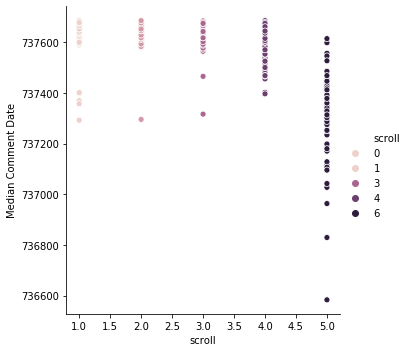

In [7]:
sns.relplot(x='scroll', y='Median Comment Date',hue='scroll', data=spam_percent)

## SKU Plots

In [ ]:
sku_plts = ['spam', 'Number of Comments','Median Comment Date','Spam Percent','Rank','Total Pictures']
for i in sku_plts:
    sns.relplot(x='SKU', y=i,hue='scroll', data=spam_percent)
    plt.show()

### spam_percent: SKU v. Number of Comments

In [ ]:
X = spam_percent[['SKU', 'Number of Comments']]
kmeans1 = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans1.predict(X)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

corrs = []
spam_percent['sku_com'] = kmeans1.labels_

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(10, 7))
# plt.title("Customer Dendograms")
# dend = shc.dendrogram(shc.linkage(X, method='ward'))
# cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
# cluster.fit_predict(X)
# # plt.scatter(X.iloc[:,0],X.iloc[:,1], c=cluster.labels_, cmap='rainbow')

In [ ]:
# corrs = []
# X = spam_percent[['Total Pictures','SKU']]

# # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
# for k in range(3, 11):
#     kmeans = KMeans(n_clusters=k).fit(X)
#     spam_percent['sku_pics'] = kmeans.labels_
#     corrs.append(spam_percent[['sku_pics', 'page']].corr().loc['page','sku_pics'])

# # plot the cost against K values 
# plt.plot(range(3, 11), corrs, color ='g', linewidth ='3') 
# plt.xlabel("clusters") 
# plt.ylabel("correlation") 
# plt.show() # clear the plot 

In [ ]:
spam_percent = pd.get_dummies(spam_percent,columns=['sku_com'], prefix='sku_com', drop_first=True)

### spam_percent: SKU v. Total Pictures

In [ ]:
sns.relplot(x='SKU', y='Total Pictures',hue='page', data=spam_percent)
plt.show()
X = spam_percent[['SKU', 'Total Pictures']]
kmeans2 = KMeans(n_clusters=4, random_state=0).fit(X)
y_kmeans = kmeans2.predict(X)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans2.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
# accuracy = []
# precision = []
# X = spam_percent[['Total Pictures','SKU']]

# # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
# for k in range(3, 11):
#     kmeans = KMeans(n_clusters=k).fit(X)
#     spam_percent['sku_pics'] = kmeans.labels_
#     #corrs.append(spam_percent[['sku_pics', 'page']].corr().loc['page','sku_pics'])
#     accuracy.append(accuracy_score(spam_percent['sku_pics'], spam_percent['page']))
#     precision.append(precision_score(spam_percent['sku_pics'], spam_percent['page'], average='weighted'))

# # plot the cost against K values 
# plt.plot(range(3, 11), precision, color ='g', linewidth ='3') 
# plt.xlabel("clusters") 
# plt.ylabel("precision") 
# plt.show() # clear the plot 


# # plot the cost against K values 
# plt.plot(range(3, 11), accuracy, color ='g', linewidth ='3') 
# plt.xlabel("clusters") 
# plt.ylabel("accuracy") 
# plt.show() # clear the plot 

In [ ]:
spam_percent['sku_pics'] = kmeans2.labels_

In [ ]:
spam_percent = pd.get_dummies(spam_percent, columns=['sku_pics'], prefix='sku_pics', drop_first=True)


### spam_percent: SKU v. Median Comment Date

In [ ]:
sns.relplot(x='SKU', y='Median Comment Date',hue='page', data=spam_percent)
plt.show()
X = spam_percent[['SKU', 'Median Comment Date']]
kmeans3 = KMeans(n_clusters=4, random_state=0).fit(X)
y_kmeans = kmeans3.predict(X)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans3.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
spam_percent['sku_medcom'] = kmeans3.labels_

In [ ]:
spam_percent = pd.get_dummies(spam_percent, columns=['sku_medcom'], prefix='sku_medcom', drop_first=True)

In [ ]:
spam_percent.columns

### spam_percent: SKU v. Spam Percent

In [ ]:
sns.relplot(x='SKU', y='Spam Percent',hue='page', data=spam_percent)
plt.show()
X = spam_percent[['SKU', 'Spam Percent']]
kmeans4 = KMeans(n_clusters=4, random_state=0).fit(X)
y_kmeans = kmeans4.predict(X)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans4.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
spam_percent['sku_spam'] = kmeans4.labels_
spam_percent = pd.get_dummies(spam_percent,columns=['sku_spam'], prefix='sku_spam', drop_first=True)

## Spam Plots

In [ ]:
rank_plts = ['Number of Comments','Median Comment Date','Rank','Total Pictures']
for i in rank_plts:
    sns.relplot(x='spam', y=i,hue='page', data=spam_percent)
    plt.show()

### spam_percent: Median Comment Date v. Spam

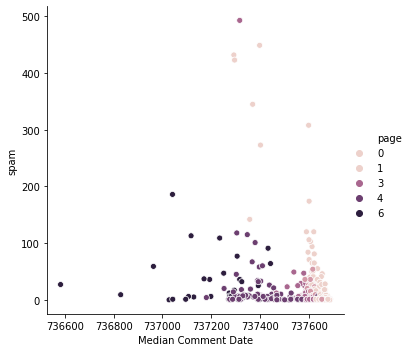

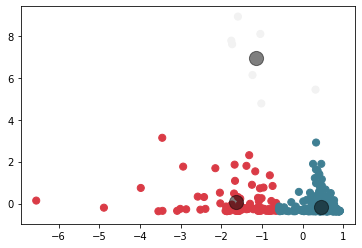

In [282]:
sns.relplot(x='Median Comment Date', y='spam',hue='page', data=spam_percent)
plt.show()
X = preprocessing.scale(spam_percent[['Median Comment Date', 'spam']])
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
spam_percent['meddate_spam'] = kmeans.labels_

spam_percent = pd.get_dummies(spam_percent,columns=['meddate_spam'], prefix='meddate_spam', drop_first=True)


## Number of Comments Plot

In [ ]:
sns.relplot(x='Number of Comments',y='Median Comment Date',hue='scroll', data=spam_percent)

### spam_percent: Number of Comments v. Median Comment Date

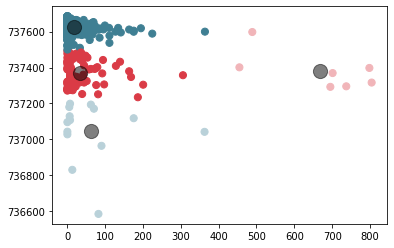

In [285]:
X = spam_percent[['Median Comment Date', 'Number of Comments']]
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X.iloc[:, 1], X.iloc[:, 0], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

In [ ]:
# accuracy = []
# precision = []
# X = spam_percent[['Median Comment Date', 'Number of Comments']]

# # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
# for k in range(3, 11):
#     kmeans = KMeans(n_clusters=k).fit(X)
#     spam_percent['meddate_com'] = kmeans.labels_
#     #corrs.append(spam_percent[['sku_pics', 'page']].corr().loc['page','sku_pics'])
#     accuracy.append(accuracy_score(spam_percent['meddate_com'], spam_percent['page']))
#     precision.append(precision_score(spam_percent['meddate_com'], spam_percent['page'], average='weighted'))

# # plot the cost against K values 
# plt.plot(range(3, 11), precision, color ='g', linewidth ='3') 
# plt.xlabel("clusters") 
# plt.ylabel("precision") 
# plt.show() # clear the plot 


# # plot the cost against K values 
# plt.plot(range(3, 11), accuracy, color ='g', linewidth ='3') 
# plt.xlabel("clusters") 
# plt.ylabel("accuracy") 
# plt.show() # clear the plot 


In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
spam_percent['meddate_com'] = kmeans.labels_

spam_percent = pd.get_dummies(spam_percent,columns=['meddate_com'], prefix='meddate_com', drop_first=True)

### spam_percent: Number of Comments v. 75th Comment Date

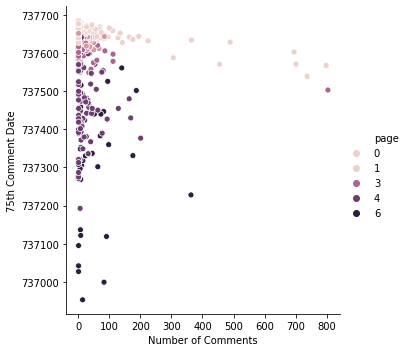

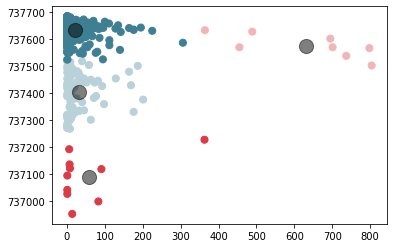

In [280]:
X = spam_percent[['75th Comment Date', 'Number of Comments']]
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)

sns.relplot(x='Number of Comments',y='75th Comment Date',hue='page', data=spam_percent)
plt.show()

plt.scatter(X.iloc[:, 1], X.iloc[:, 0], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
spam_percent['75date_com'] = kmeans.labels_

spam_percent = pd.get_dummies(spam_percent, columns=['75date_com'], prefix='75date_com',drop_first=True)


In [ ]:
spam_percent.filter(regex='75date_com').columns

### spam_percent: Number of Comments v. 25th Comment Date

In [ ]:
X = preprocessing.scale(spam_percent[['25th Comment Date', 'Number of Comments']])
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)

sns.relplot(x='Number of Comments',y='25th Comment Date',hue='page', data=spam_percent)
plt.show()

plt.scatter(X[:, 1], X[:, 0], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 15): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 15), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 14

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, kmax+1), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
spam_percent['25date_com'] = kmeans.labels_
spam_percent = pd.get_dummies(spam_percent,columns=['25date_com'], prefix='25date_com',drop_first=True)


### spam_percent: Number of Comments v. Max Comment Date

In [ ]:
X = spam_percent[['Max Comment Date', 'Number of Comments']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)

sns.relplot(x='Number of Comments',y='Max Comment Date',hue='page', data=spam_percent)
plt.show()

plt.scatter(X.iloc[:, 1], X.iloc[:, 0], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
spam_percent['maxdate_com'] = kmeans.labels_

spam_percent = pd.get_dummies(spam_percent, columns = ['maxdate_com'], prefix='maxdate_com', drop_first=True)


### spam_percent: Number of Comments v. Min Comment Date

In [ ]:
X = spam_percent[['Min Comment Date', 'Number of Comments']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)

sns.relplot(x='Number of Comments',y='Min Comment Date',hue='scroll', data=spam_percent)
plt.show()

plt.scatter(X.iloc[:, 1], X.iloc[:, 0], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
spam_percent['mindate_com'] = kmeans.labels_

spam_percent = pd.get_dummies(spam_percent,columns=['mindate_com'], prefix='mindate_com', drop_first=True)

### spam_percent: Number of Comments v. Mean Comment Date

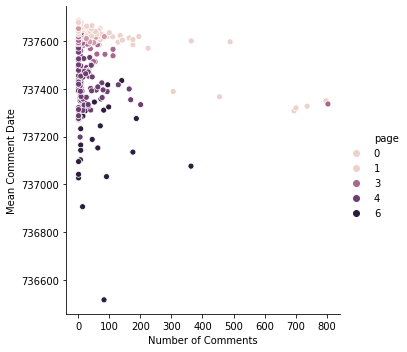

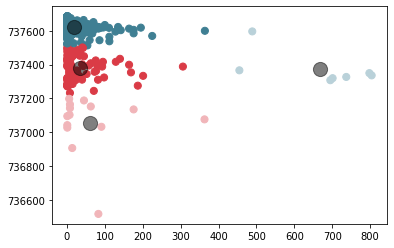

In [281]:
X = spam_percent[['Mean Comment Date', 'Number of Comments']]
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)

sns.relplot(x='Number of Comments',y='Mean Comment Date',hue='page', data=spam_percent)
plt.show()

plt.scatter(X.iloc[:, 1], X.iloc[:, 0], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
spam_percent['meandate_com'] = kmeans.labels_

spam_percent = pd.get_dummies(spam_percent,columns=['meandate_com'], prefix='meandate_com', drop_first=True)

### spam_percent: Number of Comments v. IQR Date

In [ ]:
X = preprocessing.scale(spam_percent[['IQR Date', 'Number of Comments']])
kmeans = KMeans(n_clusters=2).fit(X)
y_kmeans = kmeans.predict(X)

sns.relplot(x='Number of Comments',y='IQR Date',hue='page', data=spam_percent)
plt.show()

plt.scatter(X[:, 1], X[:, 0], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
spam_percent['iqrdate_com'] = kmeans.labels_

spam_percent= pd.get_dummies(spam_percent,columns=['iqrdate_com'], prefix='iqrdate_com',drop_first=True)

### reviews_cleaned: Word Cloud

In [ ]:
print('Non-unique comments')
spam_words = ' '.join(list(reviews_cleaned[reviews_cleaned['non_unique'] == 1]['Comment']))
spam_wc = WordCloud(width =512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

print('Unique comments')
spam_words = ' '.join(list(reviews_cleaned[reviews_cleaned['non_unique'] == 0]['Comment']))
spam_wc = WordCloud(width =512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

print('Spam')
spam_words = ' '.join(list(reviews_cleaned[reviews_cleaned['spam'] == 1]['Comment']))
spam_wc = WordCloud(width =512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

print('Non-spam')
spam_words = ' '.join(list(reviews_cleaned[reviews_cleaned['spam'] == 0]['Comment']))
spam_wc = WordCloud(width =512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Items 

In [ ]:
 # # One hot encode sizes 

items_cleaned = pd.get_dummies(items_cleaned,columns=['Size 0'], prefix='size',drop_first=True)

#df = pd.get_dummies(df, columns=['type'])

In [ ]:
items_cleaned.columns

In [ ]:
items_cleaned.describe()

In [ ]:
items_cleaned.corr()

In [ ]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(items_cleaned.corr(), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## items_cleaned: Rank Plots

In [ ]:
items_cleaned.head()

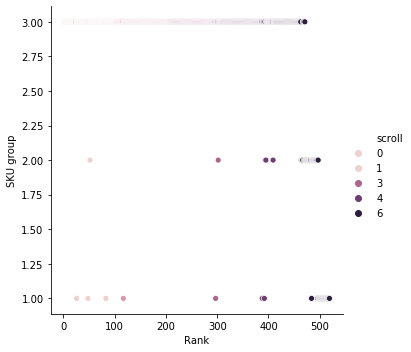

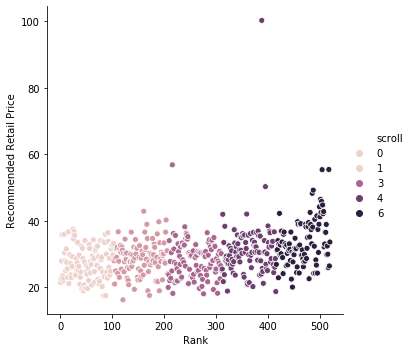

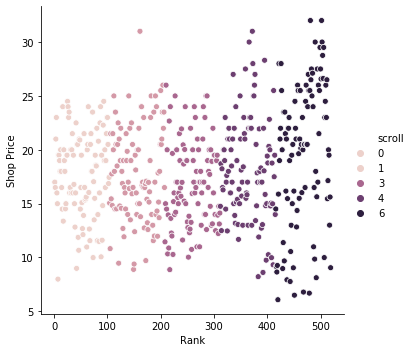

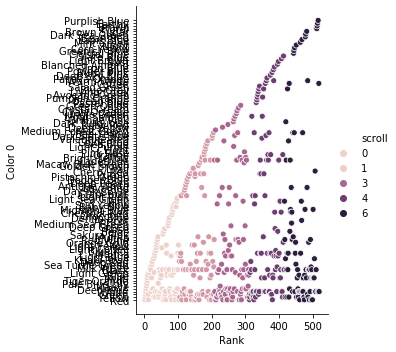

ValueError: Could not interpret input 'Size 0'

In [273]:
rank_plts = ['SKU group', 'Recommended Retail Price', 'Shop Price','Color 0', 'Size 0','Item Name Length','Number of Available Colors']
for i in rank_plts:
    sns.relplot(x='Rank', y=i,hue='scroll', data=items_cleaned)
    plt.show()

## items_cleaned: SKU Plots 

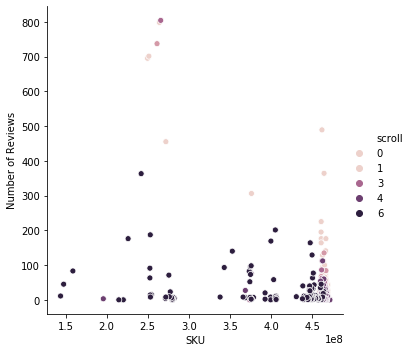

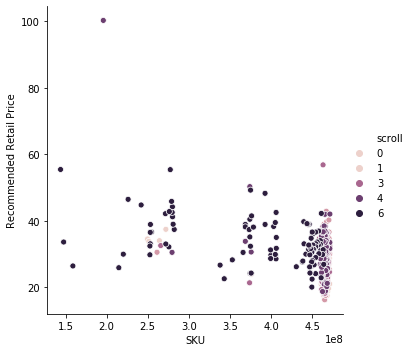

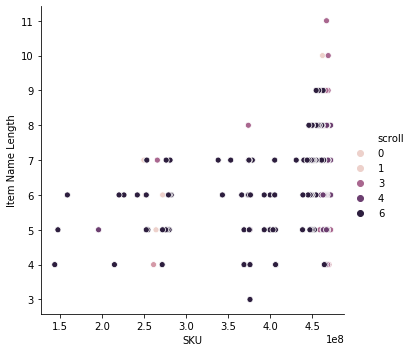

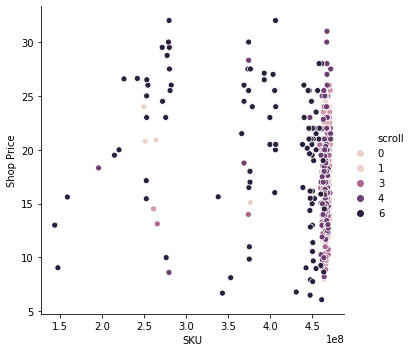

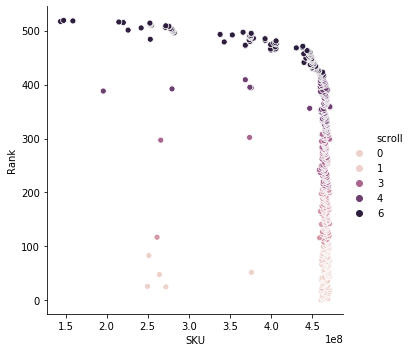

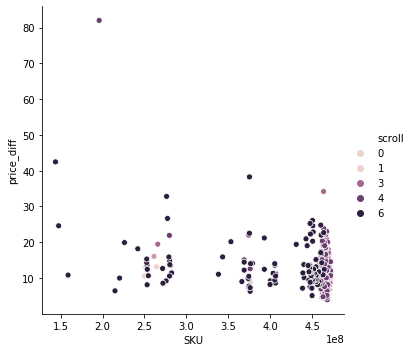

In [274]:
sku_plts = ['Number of Reviews','Recommended Retail Price','Item Name Length','Shop Price','Rank', 'price_diff']

for i in sku_plts:
    sns.relplot(x='SKU', y=i,hue='scroll', data=items_cleaned)
    plt.show()

### items_cleaned: SKU vs. price_dif

In [ ]:
sns.relplot(x='price_diff', y='SKU',hue='scroll', data=items_cleaned)
plt.show()
X = items_cleaned[['price_diff','SKU']]
kmeans2 = KMeans(n_clusters=3, random_state=0).fit(X)
y_kmeans = kmeans2.predict(X)


plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans2.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
items_cleaned['sku_pdif'] = kmeans2.labels_

items_cleaned = pd.get_dummies(items_cleaned,columns=['sku_pdif'], prefix='sku_pdif', drop_first=True)

### items_cleaned: SKU group v. Number of Reviews

In [ ]:
sns.relplot(x='SKU', y='Number of Reviews',hue='scroll', data=items_cleaned)
plt.show()
X = items_cleaned[['SKU','Number of Reviews']]
kmeans3 = KMeans(n_clusters=4, random_state=0).fit(X)
y_kmeans = kmeans3.predict(X)


plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans3.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
items_cleaned['sku_rev'] = kmeans3.labels_

items_cleaned = pd.get_dummies(items_cleaned,columns=['sku_rev'], prefix='sku_rev', drop_first=True)


### items_cleaned: SKU group v. RRP

In [ ]:
sns.relplot(x='SKU', y='Recommended Retail Price',hue='scroll', data=items_cleaned)
plt.show()
X = items_cleaned[['SKU','Recommended Retail Price']]
kmeans1 = KMeans(n_clusters=4, random_state=0).fit(X)
y_kmeans = kmeans1.predict(X)


plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
items_cleaned['sku_rrp'] = kmeans1.labels_

items_cleaned = pd.get_dummies(items_cleaned,columns=['sku_rrp'], prefix='sku_rrp', drop_first=True)

## items_cleaned: RRP Plots

In [ ]:
rrp_plts = ['Number of Reviews','Rank','Number of Available Colors','Shop Price']

for i in rrp_plts:
    sns.relplot(x='Recommended Retail Price', y=i,hue='scroll', data=items_cleaned)
    plt.show()

In [ ]:
sns.relplot(x='Recommended Retail Price', y='Number of Available Colors',hue='scroll', data=items_cleaned,y_jitter=True)
plt.show()
X = items_cleaned[['Recommended Retail Price','Number of Available Colors']]
kmeans4 = KMeans(n_clusters=4, random_state=0).fit(X)
y_kmeans = kmeans4.predict(X)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans4.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
items_cleaned['rrp_col'] = kmeans4.labels_
items_cleaned = pd.get_dummies(items_cleaned,columns=['rrp_col'], prefix='rrp_col', drop_first=True)

## items_cleaned: Number of Reviews Plots

In [ ]:
num_review_plts = ['Item Name Length','Rank','Number of Available Colors']
for i in num_review_plts:
    sns.relplot(x='Number of Reviews', y=i,hue='scroll', data=items_cleaned)
    plt.show()

### items_cleaned: Number of Reviews v. Number of Available Colors

In [ ]:
sns.relplot(x='Number of Available Colors', y='Number of Reviews',hue='scroll', data=items_cleaned)
plt.show()
X = preprocessing.scale(items_cleaned[['Number of Available Colors','Number of Reviews']])
kmeans5 = KMeans(n_clusters=7, random_state=0).fit(X)
y_kmeans = kmeans5.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans5.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:

cost =[] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

# plot the cost against K values 
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show() # clear the plot 

In [ ]:
# SKU labels
items_cleaned['rev_col'] = kmeans5.labels_
items_cleaned = pd.get_dummies(items_cleaned,columns=['rev_col'], prefix='rev_col', drop_first=True)

In [ ]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
        
        >>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))
                array([[1, 0, 0],
                       [1, 0, 1]])
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = [[1 if (i.find(j) > -1) else 0 for j in words] for i in texts]
    #indicator_array = [1 for i in words if (j.string in i for j in texts)]
    return indicator_array

words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

def count_words_in_texts(words, texts, number):
    indicator_array = [[1 if (i.find(j) > number) else 0 for j in words] for i in texts]
    #indicator_array = [1 for i in words if (j.string in i for j in texts)]
    return indicator_array

### Seeing if primary color impacts ranking

In [ ]:
top_colors = items_cleaned['Color 0'].value_counts().index[0:2]
#items_cleaned['Color 0'].value_counts()

In [ ]:
items_cleaned['Top Colors'] = [0] * len(items_cleaned)
for i in range(0,len(items_cleaned)):
    if items_cleaned.loc[i, 'Color 0'] in top_colors:
        items_cleaned.loc[i, 'Top Colors'] = 1

In [ ]:
sns.relplot(x='Rank', y='Number of Reviews', hue='Top Colors', data=items_cleaned)

In [ ]:
# # One hot encode color on model
items_primary_colors_encode = (items_cleaned['Color 0']).str.get_dummies(' ') 

# merge 'scroll' and primary colors into dataframe
items_cleaned = pd.concat([items_cleaned.reset_index(drop=True),items_primary_colors_encode.reset_index(drop=True)], axis=1)
# items_primary_colors_scroll_merged

# # One hot encode item name
items_item_name_encode = items_cleaned['Item Name'].map(str).str.get_dummies(' ') 

items_cleaned = pd.concat([items_cleaned.reset_index(drop=True),items_item_name_encode.reset_index(drop=True)], axis=1)
# items_primary_colors_scroll_merged

In [2]:
#items_cleaned.to_csv (r'items_cleaned_kmeans.csv', index=False)
#reviews_cleaned.to_csv (r'reviews_cleaned.csv', index=False)
#spam_percent.to_csv (r'spam_percent_kmeans.csv', index=False)

spam_percent = pd.read_csv(r'spam_percent_kmeans.csv')
items_cleaned = pd.read_csv(r'items_cleaned_kmeans.csv')
reviews_cleaned = pd.read_csv(r'reviews_cleaned.csv')

# Phase 4: Modeling the Data

In [ ]:
#items_cleaned.to_csv (r'items_cleaned.csv', index=False)
#reviews_cleaned.to_csv (r'reviews_cleaned.csv', index=False)
#spam_percent.to_csv (r'spam_percent.csv', index=False)

#no kmeans
#spam_percent = pd.read_csv(r'spam_percent.csv')
#items_cleaned = pd.read_csv(r'items_cleaned.csv')
#reviews_cleaned = pd.read_csv(r'reviews_cleaned.csv')

## Get relevant columns

In [3]:
items_cleaned.columns # length - 348

Index(['Rank', 'SKU', 'Item Name', 'Shop Price', 'Recommended Retail Price',
       'Deals', 'Available Colors', 'Overall Rating', 'Number of Reviews',
       'True Fit Percentage',
       ...
       'Up', 'V', 'Vacation', 'Velvet', 'Waist', 'Wasit', 'Wrap', 'X', 'ZAFUL',
       'Zipper'],
      dtype='object', length=348)

In [4]:
spam_percent.columns

Index(['SKU', 'spam', 'Number of Comments', 'Median Comment Date',
       'Time (numerical)', 'Median Comment Length',
       'Median Number of Pictures', 'Total Pictures', 'Spam Percent', 'Rank',
       'scroll', 'page', 'Mean Comment Date', '25th Comment Date',
       '75th Comment Date', 'Min Comment Date', 'Max Comment Date',
       'Range Date', 'IQR Date', 'sku_com_1', 'sku_com_2', 'sku_com_3',
       'sku_pics_1', 'sku_pics_2', 'sku_pics_3', 'sku_medcom_1',
       'sku_medcom_2', 'sku_medcom_3', 'sku_spam_1', 'sku_spam_2',
       'sku_spam_3', 'meddate_spam_1', 'meddate_spam_2', 'meddate_com_1',
       'meddate_com_2', 'meddate_com_3', '75date_com_1', '75date_com_2',
       '75date_com_3', '25date_com_1', '25date_com_2', 'maxdate_com_1',
       'maxdate_com_2', 'mindate_com_1', 'mindate_com_2', 'meandate_com_1',
       'meandate_com_2', 'meandate_com_3', 'iqrdate_com_1'],
      dtype='object')

In [5]:
items_model = items_cleaned.drop(['Deals','Available Colors','True Fit Percentage','Too Small Percentage','Too Large Percentage','Overall Rating','Rank','scroll','page'],axis=1)
items_model = pd.merge(items_model,spam_percent,on='SKU')

## Split training and testing data

In [6]:
# splitting training and testing data

items_train = items_model.sample(frac=0.8,random_state=200) #random state is a seed value
items_test = items_model.drop(items_train.index)


In [40]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
num_feats= 20
X = items_train[items_train.corr().columns].drop(['scroll','Rank','page'], axis=1)
y = items_train['scroll']
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(preprocessing.scale(X), y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 382 features.
Fitting estimator with 372 features.
Fitting estimator with 362 features.
Fitting estimator with 352 features.
Fitting estimator with 342 features.
Fitting estimator with 332 features.


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 322 features.
Fitting estimator with 312 features.


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 302 features.
Fitting estimator with 292 features.
Fitting estimator with 282 features.
Fitting estimator with 272 features.
Fitting estimator with 262 features.
Fitting estimator with 252 features.
Fitting estimator with 242 features.
Fitting estimator with 232 features.
Fitting estimator with 222 features.
Fitting estimator with 212 features.
Fitting estimator with 202 features.
Fitting estimator with 192 features.
Fitting estimator with 182 features.
Fitting estimator with 172 features.
Fitting estimator with 162 features.
Fitting estimator with 152 features.
Fitting estimator with 142 features.
Fitting estimator with 132 features.
Fitting estimator with 122 features.
Fitting estimator with 112 features.
Fitting estimator with 102 features.
Fitting estimator with 92 features.
Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting

In [41]:
rfe_feature

['Number of Reviews',
 'size_L',
 'size_M',
 'size_S',
 'Flower',
 'Hem',
 'Off',
 'Strap',
 'spam',
 'Number of Comments',
 'Median Comment Date',
 'Total Pictures',
 'Mean Comment Date',
 '25th Comment Date',
 '75th Comment Date',
 'Min Comment Date',
 'Max Comment Date',
 'meddate_spam_2',
 '75date_com_1',
 '25date_com_1']

In [7]:

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

X = items_train[items_train.corr().columns].drop(['scroll','Rank','page'], axis=1)
y = items_train['scroll']
num_feats=40

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

40 selected features


In [8]:
embeded_rf_feature

['SKU',
 'Shop Price',
 'Recommended Retail Price',
 'Number of Reviews',
 'Item Name Length',
 'Number of Available Colors',
 'price_diff',
 'size_L',
 'size_M',
 'size_S',
 'rrp_col_1',
 'Blue',
 'Ditsy',
 'Floral.1',
 'Mini',
 'Print',
 'Sleeve',
 'Tiny',
 'ZAFUL',
 'spam',
 'Number of Comments',
 'Median Comment Date',
 'Time (numerical)',
 'Median Comment Length',
 'Median Number of Pictures',
 'Total Pictures',
 'Spam Percent',
 'Mean Comment Date',
 '25th Comment Date',
 '75th Comment Date',
 'Min Comment Date',
 'Max Comment Date',
 'Range Date',
 'IQR Date',
 'meddate_spam_2',
 'meddate_com_3',
 '75date_com_1',
 '25date_com_1',
 'meandate_com_1',
 'meandate_com_3']

## One hot encode `Item Names`

In [ ]:

# # sort by scroll in descending order
# scroll_name_corr = item_name_scroll_merged.corr().abs().sort_values(by='scroll', axis=0, ascending=False).iloc[:,0]
# scroll_name_corr # correlations w/ scroll and all item name strings

# most_corr_names = scroll_name_corr[2:].index
# data = np.array(words_in_texts(most_corr_names, items_train['Item Name']))

# dict = {
#     most_corr_names[0]: data[:, 0],
#     most_corr_names[1]: data[:, 1],
#     most_corr_names[2]: data[:, 2],
#     most_corr_names[3]: data[:, 3],
#     most_corr_names[4]: data[:, 4],
#     most_corr_names[5]: data[:, 5],
#     most_corr_names[6]: data[:, 6],
#     most_corr_names[7]: data[:, 7],
#     most_corr_names[8]: data[:, 8],
#     most_corr_names[9]: data[:, 9],
#     most_corr_names[10]: data[:, 10],
#     most_corr_names[11]: data[:, 11],
#     most_corr_names[12]: data[:, 12]
#     #most_corr_names[13]: data[:, 13],
#     #most_corr_names[14]: data[:, 14],
#     #most_corr_names[15]: data[:, 15],
#     #most_corr_names[16]: data[:, 16],
#     #most_corr_names[17]: data[:, 17],
#     #most_corr_names[18]: data[:, 18],
#     #most_corr_names[19]: data[:, 19]
# }

# # plot 
# fig_dims = (24, 8)
# fig, ax = plt.subplots(figsize=fig_dims)
# train_melt = pd.DataFrame(dict)
# train_melt['type'] = items_cleaned['scroll']
# # train_melt = train_melt.melt('typ')
# sns.barplot(x="variable", y="value", hue="type",ax=ax, data=train_melt)

# # words = scroll_name_corr[words_index].index


# # words = ['Long', 'Ditsy', 'Open', 'A', 'Line', 'Ruffled', 'ZAFUL', 'Up', 'Floral', 'Low', 'Criss', 'Knotted','One','Tiered','Cap']
# #words = scroll_name_corr[2:].index


## One hot encode `Color 0`

In [ ]:

# # sort dataframe by descending correlations
# scroll_primary_color_corr =  .corr().abs().sort_values(by='scroll', axis=0, ascending=False).iloc[:,0]
# # select top correlated features
# primary_colors_scroll = scroll_primary_color_corr[2:].index

# primary_colors_scroll
# data = np.array(words_in_texts(primary_colors_scroll, items_train['Color 0']))



# dict = {
#     primary_colors_scroll[0]: data[:, 0],
#     primary_colors_scroll[1]: data[:, 1],
#     primary_colors_scroll[2]: data[:, 2],
#     primary_colors_scroll[3]: data[:, 3],
#     primary_colors_scroll[4]: data[:, 4],
#     primary_colors_scroll[5]: data[:, 5],
#     primary_colors_scroll[6]: data[:, 6],
#     primary_colors_scroll[7]: data[:, 7],
#     primary_colors_scroll[8]: data[:, 8],
#     primary_colors_scroll[9]: data[:, 9],
#     primary_colors_scroll[10]: data[:, 10],
#     primary_colors_scroll[11]: data[:, 11],
#     primary_colors_scroll[12]: data[:, 12],
#     #most_corr_names[13]: data[:, 13],
#     #most_corr_names[14]: data[:, 14],
#     #most_corr_names[15]: data[:, 15],
#     #most_corr_names[16]: data[:, 16],
#     #most_corr_names[17]: data[:, 17],
#     #most_corr_names[18]: data[:, 18],
#     #most_corr_names[19]: data[:, 19]
# }


# # plot most correlated primary colors with scroll
# fig_dims = (12, 8)
# fig, ax = plt.subplots(figsize=fig_dims)

# train_melt = pd.DataFrame(dict)
# train_melt['type'] = items_cleaned['scroll'] #.map({0: 'ham', 1: 'spam'})
# train_melt = train_melt.melt('type')
# train_melt
# sns.barplot(x="variable", y="value", hue="type",ax=ax, data=train_melt)
# plt.show()

# X_train = preprocessing.scale(np.array((words_in_texts(primary_colors_scroll, items_cleaned['Color 0']))))
# Y_train = items_cleaned['scroll']

# model = LogisticRegression(multi_class='multinomial',solver ='newton-cg').fit(X_train, Y_train)
# model

# training_accuracy = model.score(X_train, Y_train)
# print("Training Accuracy: ", training_accuracy)
# model.predict(X_train)


# predictions = model.predict(X_train)
# cm = metrics.confusion_matrix(Y_train, predictions)
# print(cm)

## Testing Item Name encode with items_train to predict scroll and page using Logistic Regression and Lasso

In [9]:
rfe_feature[-8:]

NameError: name 'rfe_feature' is not defined

In [73]:
for i in np.arange(5,60):
    top7 = items_train.corr().abs().sort_values(by='scroll', axis=0, ascending=False).loc[:,'scroll'][3:i].index
    X = preprocessing.scale(items_train[top7])
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test

    lm = LogisticRegression()
    #lm = LogisticRegression(multi_class='multinomial',solver ='newton-cg').fit(X_train, y_train)
    lm.fit(X_train, y_train)

    y_pred = lm.predict(X_test)
    cv_scores_linreg = cross_val_score(lm,X_train,y_train,scoring='accuracy')
    print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)), i)

Mean 5-Fold CV Score: 0.5391372549019608 5
Mean 5-Fold CV Score: 0.5315294117647059 6
Mean 5-Fold CV Score: 0.5552156862745098 7
Mean 5-Fold CV Score: 0.515921568627451 8
Mean 5-Fold CV Score: 0.5468235294117647 9
Mean 5-Fold CV Score: 0.5748235294117647 10
Mean 5-Fold CV Score: 0.5473725490196079 11
Mean 5-Fold CV Score: 0.5549803921568628 12
Mean 5-Fold CV Score: 0.5394509803921569 13
Mean 5-Fold CV Score: 0.5234509803921569 14
Mean 5-Fold CV Score: 0.492235294117647 15
Mean 5-Fold CV Score: 0.5631372549019609 16
Mean 5-Fold CV Score: 0.5590588235294118 17
Mean 5-Fold CV Score: 0.5668235294117647 18
Mean 5-Fold CV Score: 0.511686274509804 19
Mean 5-Fold CV Score: 0.5474509803921569 20
Mean 5-Fold CV Score: 0.523843137254902 21
Mean 5-Fold CV Score: 0.49192156862745096 22
Mean 5-Fold CV Score: 0.511921568627451 23
Mean 5-Fold CV Score: 0.516 24
Mean 5-Fold CV Score: 0.5826666666666667 25
Mean 5-Fold CV Score: 0.5355294117647059 26
Mean 5-Fold CV Score: 0.527607843137255 27
Mean 5-Fold

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean 5-Fold CV Score: 0.5395294117647058 40
Mean 5-Fold CV Score: 0.523686274509804 41
Mean 5-Fold CV Score: 0.5356078431372548 42
Mean 5-Fold CV Score: 0.5395294117647059 43
Mean 5-Fold CV Score: 0.5749019607843138 44
Mean 5-Fold CV Score: 0.5469019607843137 45
Mean 5-Fold CV Score: 0.5314509803921569 46
Mean 5-Fold CV Score: 0.5433725490196079 47


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.539607843137255 48


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.5394509803921569 49


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.5313725490196078 50


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.5551372549019609 51


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.507686274509804 52


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean 5-Fold CV Score: 0.5552941176470588 53


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.5712156862745099 54


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.5827450980392157 55


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.5274509803921569 56


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.5630588235294118 57


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.5232941176470588 58


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean 5-Fold CV Score: 0.5155294117647059 59


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [225]:
for i in np.arange(5,100):
    X = preprocessing.scale(items_train[rfe_feature[-i:]])
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test

    lm = LogisticRegression()
    #lm = LogisticRegression(multi_class='multinomial',solver ='newton-cg').fit(X_train, y_train)
    lm.fit(X_train, y_train)

    y_pred = lm.predict(X_test)
    cv_scores_linreg = cross_val_score(lm,X_train,y_train,scoring='accuracy')
    print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)), i)

Mean 5-Fold CV Score: 0.40925490196078423 5
Mean 5-Fold CV Score: 0.4290980392156863 6
Mean 5-Fold CV Score: 0.4213333333333333 7
Mean 5-Fold CV Score: 0.4804705882352941 8
Mean 5-Fold CV Score: 0.5314509803921569 9
Mean 5-Fold CV Score: 0.5549019607843138 10
Mean 5-Fold CV Score: 0.5474509803921569 11
Mean 5-Fold CV Score: 0.5512156862745098 12
Mean 5-Fold CV Score: 0.5824313725490196 13
Mean 5-Fold CV Score: 0.5669803921568628 14
Mean 5-Fold CV Score: 0.5981960784313726 15
Mean 5-Fold CV Score: 0.5945098039215686 16
Mean 5-Fold CV Score: 0.5431372549019609 17
Mean 5-Fold CV Score: 0.5668235294117647 18
Mean 5-Fold CV Score: 0.6141960784313726 19
Mean 5-Fold CV Score: 0.5905882352941176 20
Mean 5-Fold CV Score: 0.5746666666666667 21
Mean 5-Fold CV Score: 0.5509803921568628 22
Mean 5-Fold CV Score: 0.5829803921568628 23
Mean 5-Fold CV Score: 0.6022745098039216 24
Mean 5-Fold CV Score: 0.5671372549019609 25
Mean 5-Fold CV Score: 0.5472941176470589 26
Mean 5-Fold CV Score: 0.578980392156

# Random Forest

In [258]:
X = preprocessing.scale(items_train[top40])
Y = items_train['scroll']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test

# {'max_features': 'sqrt', 'n_estimators': 31}
rf = RandomForestClassifier(n_estimators=31,  max_features = 'sqrt')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test) 

cv_scores_linreg = cross_val_score(rf,X_train,y_train,scoring='accuracy')

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(rf.score(X_test, y_test)))
print("Training R^2: {}".format(rf.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(y_test, np.round(y_pred)))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average='weighted'))

Testing R^2: 0.5137614678899083
Training R^2: 1.0
Root Mean Squared Error: 1.121106923511292
Mean Absolute Error: 0.7064220183486238
Mean 5-Fold CV Score: 0.5865098039215686
5-Fold CV Scores: [0.64705882 0.54901961 0.56862745 0.60784314 0.56      ]
              precision    recall  f1-score   support

           1       0.52      0.73      0.60        22
           2       0.32      0.40      0.36        20
           3       0.42      0.23      0.29        22
           4       0.35      0.35      0.35        20
           5       0.95      0.80      0.87        25

    accuracy                           0.51       109
   macro avg       0.51      0.50      0.49       109
weighted avg       0.53      0.51      0.51       109

Accuracy: 0.5137614678899083
Precision: 0.5296424695951183
Recall: 0.5137614678899083


In [10]:
top40 = items_train.corr().abs().sort_values(by='scroll', axis=0, ascending=False).loc[:,'scroll'][3:43].index
top40

Index(['75th Comment Date', 'meddate_spam_2', 'Median Comment Date',
       'Mean Comment Date', '25date_com_1', 'meandate_com_1', 'meandate_com_3',
       '75date_com_1', 'meddate_com_3', 'mindate_com_2', '25th Comment Date',
       'Max Comment Date', 'Min Comment Date', 'maxdate_com_2', 'sku_rev_1',
       'sku_rrp_1', 'SKU', 'Recommended Retail Price', 'sku_medcom_2',
       'sku_pics_2', 'sku_com_2', 'sku_spam_2', 'sku_pdif_2', 'SKU group',
       'Number of Available Colors', 'rrp_col_3', 'price_diff', 'Range Date',
       'meddate_com_1', 'rrp<40', '75date_com_3', 'Ditsy', 'rev_col_5',
       'rev_col_6', 'Long', 'size_L', 'sku_pdif_1', 'rrp_col_1', 'IQR Date',
       'Maxi'],
      dtype='object')

In [259]:
print(lm.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [264]:


param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]
rfclassifier = {'n_estimators': range(1,100,10),
              #'criterion':('mae','mse'),
              'max_features':('auto','sqrt','log2')
}

logis_params = {
    'C':[1,10],
    'penalty':('l1','l2'),
    'solver':('lbfgs','liblinear')
}

GridS=GridSearchCV(lm,logis_params,cv=3)
GridS.fit(X_train,y_train)
GridS.best_params_

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: Fi

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

In [11]:
X = preprocessing.scale(items_train[top40])
Y = items_train['scroll']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test

lm = LogisticRegression(fit_intercept=True,C=1,penalty='l2',solver='lbfgs')
#lm = LogisticRegression(multi_class='multinomial',solver ='newton-cg').fit(X_train, y_train)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)
cv_scores_linreg = cross_val_score(lm,X_train,y_train,scoring='accuracy')

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(lm.score(X_test, y_test)))
print("Training R^2: {}".format(lm.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(y_test, np.round(y_pred)))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average='weighted'))

Testing R^2: 0.5779816513761468
Training R^2: 0.6771653543307087
Root Mean Squared Error: 0.9433494881965718
Mean Absolute Error: 0.5596330275229358
Mean 5-Fold CV Score: 0.5510588235294118
5-Fold CV Scores: [0.52941176 0.60784314 0.54901961 0.54901961 0.52      ]
              precision    recall  f1-score   support

           1       0.52      0.81      0.63        21
           2       0.38      0.26      0.31        23
           3       0.44      0.20      0.28        20
           4       0.42      0.69      0.52        16
           5       1.00      0.86      0.93        29

    accuracy                           0.58       109
   macro avg       0.55      0.56      0.53       109
weighted avg       0.59      0.58      0.56       109

Accuracy: 0.5779816513761468
Precision: 0.5880853346449676
Recall: 0.5779816513761468


In [12]:
X = preprocessing.scale(items_test[top40])
Y = items_test['scroll']

y_pred = lm.predict(X)
cv_scores_linreg = cross_val_score(lm,X,Y,scoring='accuracy')

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(lm.score(X, Y)))
print("Training R^2: {}".format(lm.score(X, Y)))
rmse = np.sqrt(mean_squared_error(Y, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(Y, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(Y, np.round(y_pred)))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(Y, y_pred,average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(Y, y_pred,average='weighted'))

Testing R^2: 0.5824175824175825
Training R^2: 0.5824175824175825
Root Mean Squared Error: 1.079275296129382
Mean Absolute Error: 0.6593406593406593
Mean 5-Fold CV Score: 0.5163742690058479
5-Fold CV Scores: [0.52631579 0.55555556 0.55555556 0.44444444 0.5       ]
              precision    recall  f1-score   support

           1       0.47      0.94      0.63        17
           2       0.30      0.18      0.22        17
           3       0.50      0.19      0.28        21
           4       0.61      0.78      0.68        18
           5       1.00      0.89      0.94        18

    accuracy                           0.58        91
   macro avg       0.58      0.59      0.55        91
weighted avg       0.58      0.58      0.54        91

Accuracy: 0.5824175824175825
Precision: 0.5775441949354994
Recall: 0.5824175824175825


In [187]:
confusion_matrix(y_test,y_pred)

top40
Testing R^2: 0.5596330275229358
Training R^2: 0.6535433070866141
Root Mean Squared Error: 0.8830722018960102
Mean Absolute Error: 0.5412844036697247
Mean 5-Fold CV Score: 0.5354509803921569
5-Fold CV Scores: [0.58823529 0.52941176 0.52941176 0.49019608 0.54      ]
              precision    recall  f1-score   support

           1       0.73      0.69      0.71        32
           2       0.19      0.22      0.21        18
           3       0.32      0.39      0.35        18
           4       0.50      0.39      0.44        18
           5       0.95      0.91      0.93        23

    accuracy                           0.56       109
   macro avg       0.54      0.52      0.53       109
weighted avg       0.58      0.56      0.57       109

Accuracy: 0.5596330275229358
Precision: 0.5832757456610668
Recall: 0.5596330275229358

rfe
Testing R^2: 0.5596330275229358
Training R^2: 0.6850393700787402
Root Mean Squared Error: 0.9187146985042236
Mean Absolute Error: 0.5688073394495413
Mean 5-Fold CV Score: 0.5429803921568628
5-Fold CV Scores: [0.49019608 0.66666667 0.52941176 0.56862745 0.46      ]
              precision    recall  f1-score   support

           1       0.61      0.81      0.69        21
           2       0.38      0.19      0.25        27
           3       0.23      0.20      0.21        15
           4       0.38      0.65      0.48        17
           5       0.96      0.86      0.91        29

    accuracy                           0.56       109
   macro avg       0.51      0.54      0.51       109
weighted avg       0.56      0.56      0.54       109

Accuracy: 0.5596330275229358
Precision: 0.5589820650719101
Recall: 0.5596330275229358

array([[17,  3,  0,  1,  0],
       [ 8,  5,  6,  8,  0],
       [ 3,  4,  3,  5,  0],
       [ 0,  1,  4, 11,  1],
       [ 0,  0,  0,  4, 25]])

# Logistic Regression

## Preprocessing:
Testing Accuracy: .44
Training Accuracy: 1.0
Precision: .43
Recall: .44
RMSE: 1.200
MAE: .816
Mean CV Score: .473
Matrix: Does NOT do well predicting 1,2,3,or 4

## No preprocessing:
Testing Accuracy: .3119 
Training Accuracy: .276
Precision: .286
Recall: .312
RMSE: 1.879
MAE: .283
Mean CV Score: .284
Matrix: Does NOT do well predicting 1,2,3,or 4

## Preprocessing + top:
Testing R^2: 0.5688073394495413
Training R^2: 0.610236220472441
Root Mean Squared Error: 1.0579537112018993
Mean Absolute Error: 0.6238532110091743
Mean 5-Fold CV Score: 0.523607843137255
5-Fold CV Scores: [0.54901961 0.47058824 0.54901961 0.52941176 0.52      ]
              precision    recall  f1-score   support

           1       0.68      0.63      0.65        27
           2       0.35      0.37      0.36        19
           3       0.20      0.14      0.17        14
           4       0.46      0.52      0.49        23
           5       0.86      0.92      0.89        26

    accuracy                           0.57       109
   macro avg       0.51      0.52      0.51       109
weighted avg       0.56      0.57      0.56       109

Accuracy: 0.5688073394495413
Precision: 0.556982558725678
Recall: 0.5688073394495413
Matrix: Does well in predicting 5, 1 but not really, 2/3/4 are random

## No preprocessing + top:
Testing Accuracy: .3119 
Training Accuracy: .276
Precision: .288
Recall: .312
RMSE: 1.901
MAE: .287
Mean CV Score: .287
Matrix: Does NOT do well predicting 1,2,3,or 4; predicting everything as 1 and 5; no prediction for 3 and 4
Used column ranks from 15 - 75 and it was all basically the same accuracy

In [ ]:
# preprocessing + top:
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
# no preprocessing + top:
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
# preprocessing + all:
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
# no preprocessing + all:
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
top7 = items_train.corr().abs().sort_values(by='scroll', axis=0, ascending=False).loc[:,'scroll'][3:25].index
top7

In [271]:
X = preprocessing.scale(items_train[top40])
Y = items_train['scroll']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test

lm_l = Lasso(fit_intercept=False)
lm_l.fit(X_train, y_train)

y_pred = lm_l.predict(X_test)
y_pred =  [5 if i > 5 else i for i in y_pred]
y_pred =  [1 if i < 1 else int(i) for i in y_pred]

cv_scores_linreg = cross_val_score(lm_l,X_train,y_train)

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(lm_l.score(X_test, y_test)))
print("Training R^2: {}".format(lm_l.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(y_test, y_pred))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average='weighted'))

Testing R^2: -4.839126523268176
Training R^2: -4.030640029808822
Root Mean Squared Error: 2.5896760450582663
Mean Absolute Error: 2.1559633027522938
Mean 5-Fold CV Score: -4.13059554369176
5-Fold CV Scores: [-4.40155502 -4.60075265 -4.04348959 -3.66693471 -3.94024575]
              precision    recall  f1-score   support

           1       0.18      1.00      0.31        20
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        27

    accuracy                           0.18       109
   macro avg       0.04      0.20      0.06       109
weighted avg       0.03      0.18      0.06       109

Accuracy: 0.1834862385321101
Precision: 0.03366719973066241
Recall: 0.1834862385321101


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Lasso Regression

## Preprocessing:
Testing R^2: -0.0009146118387355351
Training R^2: 0.0
Root Mean Squared Error: 1.5174822218325925
Mean Absolute Error: 1.348623853211009
Mean 5-Fold CV Score: -0.017792120888463624
5-Fold CV Scores: [-0.02789701 -0.00424564 -0.00492708 -0.02314933 -0.02874154]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        23
           3       0.13      1.00      0.23        14
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        28

    accuracy                           0.13       109
   macro avg       0.03      0.20      0.05       109
weighted avg       0.02      0.13      0.03       109

Accuracy: 0.12844036697247707
Precision: 0.0164969278680245

## No preprocessing:
Testing R^2: 0.48765299589483047
Training R^2: 0.6022126887167225
Root Mean Squared Error: 1.176996644395145
Mean Absolute Error: 0.908256880733945
Mean 5-Fold CV Score: 0.4486458348110715
5-Fold CV Scores: [ 0.57681577  0.63006374  0.65145061 -0.12279168  0.50769074]
              precision    recall  f1-score   support

           1       0.44      0.19      0.27        21
           2       0.30      0.88      0.45        24
           3       0.15      0.11      0.12        19
           4       0.09      0.05      0.06        21
           5       1.00      0.29      0.45        24

    accuracy                           0.32       109
   macro avg       0.40      0.30      0.27       109
weighted avg       0.42      0.32      0.28       109

Accuracy: 0.3211009174311927
Precision: 0.4171545779044782
Recall: 0.3211009174311927
Identifies everything as 2 basically

## Preprocessing + top:
Testing R^2: 0.5963302752293578
Training R^2: 0.594488188976378
Root Mean Squared Error: 1.1373556970672702
Mean Absolute Error: 0.8532110091743119
Mean 5-Fold CV Score: 0.5450428821405218
5-Fold CV Scores: [0.51690571 0.64133318 0.65327891 0.31658207 0.59711453]
              precision    recall  f1-score   support

           1       0.36      0.24      0.29        21
           2       0.30      0.79      0.43        24
           3       0.14      0.05      0.08        19
           4       0.08      0.05      0.06        21
           5       1.00      0.50      0.67        24

    accuracy                           0.35       109
   macro avg       0.38      0.33      0.30       109
weighted avg       0.40      0.35      0.32       109

Accuracy: 0.3486238532110092
Precision: 0.39531454783748365
Recall: 0.3486238532110092

## No preprocessing + top:
Testing R^2: 0.46079620143976097
Training R^2: 0.531436584715014
Root Mean Squared Error: 1.1963246468038928
Mean Absolute Error: 0.9357798165137615
Mean 5-Fold CV Score: 0.44780464278612647
5-Fold CV Scores: [0.4007053  0.41045862 0.58549928 0.51526944 0.32709058]
              precision    recall  f1-score   support

           1       0.67      0.08      0.14        25
           2       0.29      0.96      0.44        23
           3       0.07      0.06      0.06        18
           4       0.00      0.00      0.00        22
           5       1.00      0.24      0.38        21

    accuracy                           0.28       109
   macro avg       0.40      0.27      0.21       109
weighted avg       0.42      0.28      0.21       109

Accuracy: 0.27522935779816515
Precision: 0.4176496286588029
Recall: 0.27522935779816515
3:25 features

In [ ]:
# no preprocessing + all
metrics.confusion_matrix(y_test,y_pred)

In [ ]:
# preprocessing + top
metrics.confusion_matrix(y_test,y_pred)

In [ ]:
# no preprocessing + top
metrics.confusion_matrix(y_test,y_pred)

In [ ]:
alpha = []
err = []

for i in range(1,100):
    alpha.append(i/100)
    lm_l = Lasso(alpha=i/100, tol=2)
    err.append(np.mean(cross_val_score(lm_l, X_train,y_train,cv=5,scoring='neg_mean_squared_error')))
plt.plot(alpha,err)

In [ ]:
error = tuple(zip(alpha,err))
df_err = pd.DataFrame(error, columns=['alpha','error'])
df_err[df_err.error == max(df_err.error)]

In [269]:
X = items_train[top40]
Y = items_train['scroll']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test

lm_r = Ridge()
lm_r.fit(X_train, y_train)

y_pred = lm_r.predict(X_test)
y_pred =  [5 if i > 5 else i for i in y_pred]
y_pred =  [1 if i < 1 else int(i) for i in y_pred]

cv_scores_linreg = cross_val_score(lm_l,X_train,y_train)

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(lm_r.score(X_test, y_test)))
print("Training R^2: {}".format(lm_r.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(y_test, y_pred))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average='weighted'))

Testing R^2: 0.6333325330327781
Training R^2: 0.6819730286916791
Root Mean Squared Error: 1.121106923511292
Mean Absolute Error: 0.8348623853211009
Mean 5-Fold CV Score: 0.1561721116788852
5-Fold CV Scores: [0.30640808 0.10247086 0.20503217 0.14416951 0.02277993]
              precision    recall  f1-score   support

           1       0.72      0.52      0.60        25
           2       0.29      0.79      0.43        19
           3       0.11      0.12      0.11        16
           4       0.27      0.17      0.21        24
           5       1.00      0.24      0.39        25

    accuracy                           0.37       109
   macro avg       0.48      0.37      0.35       109
weighted avg       0.52      0.37      0.36       109

Accuracy: 0.3669724770642202
Precision: 0.5204403795962292
Recall: 0.3669724770642202


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.51686e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.25669693497923, tolerance: 0.22360000000000002
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.8431481098237, tolerance: 0.2076
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174.00102901205

# SVM

In [18]:
top7 = items_train.corr().abs().sort_values(by='scroll', axis=0, ascending=False).loc[:,'scroll'][3:30].index
top7

Index(['75th Comment Date', 'meddate_spam_2', 'Median Comment Date',
       'Mean Comment Date', '25date_com_1', 'meandate_com_1', 'meandate_com_3',
       '75date_com_1', 'meddate_com_3', 'mindate_com_2', '25th Comment Date',
       'Max Comment Date', 'Min Comment Date', 'maxdate_com_2', 'sku_rev_1',
       'sku_rrp_1', 'SKU', 'Recommended Retail Price', 'sku_medcom_2',
       'sku_pics_2', 'sku_com_2', 'sku_spam_2', 'sku_pdif_2', 'SKU group',
       'Number of Available Colors', 'rrp_col_3', 'price_diff'],
      dtype='object')

In [19]:
X = preprocessing.scale(items_train[top7])
Y = items_train['scroll']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test

#Create a svm Classifier
clf = svm.SVC(kernel='linear',C=10, gamma=.001) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

cv_scores_linreg = cross_val_score(clf,X_train,y_train, scoring='accuracy')

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(clf.score(X_test, y_test)))
print("Training R^2: {}".format(clf.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(y_test, y_pred))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average='weighted'))

Testing R^2: 0.5321100917431193
Training R^2: 0.65748031496063
Root Mean Squared Error: 1.0579537112018993
Mean Absolute Error: 0.6605504587155964
Mean 5-Fold CV Score: 0.49607843137254903
5-Fold CV Scores: [0.41176471 0.45098039 0.54901961 0.56862745 0.5       ]
              precision    recall  f1-score   support

           1       0.46      0.72      0.57        18
           2       0.25      0.18      0.21        22
           3       0.54      0.32      0.40        22
           4       0.37      0.53      0.43        19
           5       0.96      0.86      0.91        28

    accuracy                           0.53       109
   macro avg       0.52      0.52      0.50       109
weighted avg       0.55      0.53      0.52       109

Accuracy: 0.5321100917431193
Precision: 0.5469755389021443
Recall: 0.5321100917431193


# SVM

## Preprocessing:
couldn't even run lol

## No preprocessing:
couldn't even run lol

## Preprocessing + top:
Testing R^2: 0.48623853211009177
Training R^2: 0.6968503937007874
Root Mean Squared Error: 1.0404656685059097
Mean Absolute Error: 0.6972477064220184
Mean 5-Fold CV Score: 0.5632941176470588
5-Fold CV Scores: [0.58823529 0.56862745 0.37254902 0.64705882 0.64      ]
              precision    recall  f1-score   support

           1       0.51      0.71      0.60        28
           2       0.22      0.17      0.20        23
           3       0.26      0.26      0.26        19
           4       0.65      0.48      0.55        27
           5       0.85      0.92      0.88        12

    accuracy                           0.49       109
   macro avg       0.50      0.51      0.50       109
weighted avg       0.48      0.49      0.47       109

Accuracy: 0.48623853211009177
Precision: 0.478659923155336
Recall: 0.48623853211009177
3:30 features
matrix: identifies 5 well, overidentifies 1
## No preprocessing + top:
can't even run lol

In [ ]:
# preprocessing + top
metrics.confusion_matrix(y_test, y_pred)

In [39]:
top7 = items_train.corr().abs().sort_values(by='scroll', axis=0, ascending=False).loc[:,'scroll'][3:30].index
top7

Index(['75th Comment Date', 'meddate_spam_2', 'Median Comment Date',
       'Mean Comment Date', '25date_com_1', 'meandate_com_1', 'meandate_com_3',
       '75date_com_1', 'meddate_com_3', 'mindate_com_2', '25th Comment Date',
       'Max Comment Date', 'Min Comment Date', 'maxdate_com_2', 'sku_rev_1',
       'sku_rrp_1', 'SKU', 'Recommended Retail Price', 'sku_medcom_2',
       'sku_pics_2', 'sku_com_2', 'sku_spam_2', 'sku_pdif_2', 'SKU group',
       'Number of Available Colors', 'rrp_col_3', 'price_diff'],
      dtype='object')

# KNN

In [45]:
X = preprocessing.scale(items_train[top7])
Y = items_train['scroll']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test

neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = neigh.predict(X_test)

cv_scores_linreg = cross_val_score(neigh,X_train,y_train, scoring='accuracy')

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(neigh.score(X_test, y_test)))
print("Training R^2: {}".format(neigh.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(y_test, y_pred))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average='weighted'))
print('K Neighbors')


Testing R^2: 0.5688073394495413
Training R^2: 0.6732283464566929
Root Mean Squared Error: 0.9673571297684023
Mean Absolute Error: 0.5871559633027523
Mean 5-Fold CV Score: 0.4962352941176471
5-Fold CV Scores: [0.50980392 0.49019608 0.45098039 0.49019608 0.54      ]
              precision    recall  f1-score   support

           1       0.41      0.75      0.53        20
           2       0.33      0.22      0.26        23
           3       0.41      0.35      0.38        20
           4       0.64      0.41      0.50        17
           5       0.97      0.97      0.97        29

    accuracy                           0.57       109
   macro avg       0.55      0.54      0.53       109
weighted avg       0.58      0.57      0.56       109

Accuracy: 0.5688073394495413
Precision: 0.5764059698220518
Recall: 0.5688073394495413
K Neighbors


# KNN

## Preprocessing:


## No preprocessing:


## Preprocessing + top:
Testing R^2: 0.4954128440366973
Training R^2: 0.6692913385826772
Root Mean Squared Error: 1.2153453090309299
Mean Absolute Error: 0.7798165137614679
Mean 5-Fold CV Score: 0.519686274509804
5-Fold CV Scores: [0.45098039 0.47058824 0.54901961 0.60784314 0.52      ]
              precision    recall  f1-score   support

           1       0.44      0.58      0.50        26
           2       0.25      0.26      0.26        19
           3       0.28      0.26      0.27        19
           4       0.50      0.32      0.39        22
           5       0.96      0.96      0.96        23

    accuracy                           0.50       109
   macro avg       0.49      0.48      0.47       109
weighted avg       0.50      0.50      0.49       109

Accuracy: 0.4954128440366973
Precision: 0.49998500929423756
Recall: 0.4954128440366973
K Neighbors
3:30 features
Best defines  5 then 1 then rest


## No preprocessing + top:
Testing R^2: 0.3944954128440367
Training R^2: 0.6456692913385826
Root Mean Squared Error: 1.5621673957924818
Mean Absolute Error: 1.0825688073394495
Mean 5-Fold CV Score: 0.4248627450980392
5-Fold CV Scores: [0.54901961 0.47058824 0.39215686 0.37254902 0.34      ]
              precision    recall  f1-score   support

           1       0.33      0.48      0.39        25
           2       0.21      0.29      0.24        17
           3       0.38      0.30      0.33        20
           4       0.38      0.10      0.16        29
           5       0.68      0.94      0.79        18

    accuracy                           0.39       109
   macro avg       0.39      0.42      0.38       109
weighted avg       0.39      0.39      0.36       109

Accuracy: 0.3944954128440367
Precision: 0.3898165137614679
Recall: 0.3944954128440367
K Neighbors
3:30 features
Matrix best defines 5, then 1, then rest are random

In [54]:
# top7 + preprocessing
metrics.confusion_matrix(y_test, y_pred)

array([[18,  9,  1,  0,  0],
       [ 7,  5,  4,  1,  0],
       [ 4,  5,  5,  3,  0],
       [ 3,  3,  7,  6,  2],
       [ 1,  0,  0,  1, 24]])

In [50]:
# top7 + no preprocessing
metrics.confusion_matrix(y_test, y_pred)

array([[14,  3,  4,  4,  1],
       [ 9,  1,  6,  6,  0],
       [ 5,  2,  2,  4,  0],
       [ 2,  4,  3,  5,  2],
       [ 7,  1,  0,  1, 23]])

In [66]:
accuracy_score(y_train, np.round(GridS.predict(X_train)))

0.6299212598425197

In [ ]:
alpha = []
err = []

for i in range(1,1000):
    alpha.append(i/100000)
    lm_l = Lasso(alpha=i/100000, tol=2)
    err.append(np.mean(cross_val_score(lm_l, X_train,y_train,cv=5,scoring='neg_mean_squared_error')))
plt.plot(alpha,err)

In [ ]:
error = tuple(zip(alpha,err))
df_err = pd.DataFrame(error, columns=['alpha','error'])
df_err[df_err.error == max(df_err.error)]

# Grid Search

In [234]:
params={'kernel': ('linear','poly','rbf','sigmoid'),
       'C': [1,52,10],
       'degree': [3,8],
       'coef0': [.001,10,.5],
       'gamma': ['auto','scale']}

parameters = {'n_estimators': range(1,100,10),
              'criterion':('mse','mae'),
              'max_features':('auto','sqrt','log2')
    
}

GridS=GridSearchCV(SVModel,params,cv=5)
GridS.fit(X,Y)
GridS.best_params_

{'C': 10, 'coef0': 0.001, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}

In [233]:
X = preprocessing.scale(items_train[embeded_rf_feature])
Y = items_train['scroll']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test


SVModel = SVC(kernel='linear',C=1,gamma='auto',coef0=.001,degree=3)
SVModel.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = SVModel.predict(X_test)

cv_scores_linreg = cross_val_score(SVModel,X_train,y_train, scoring='accuracy')

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(SVModel.score(X_test, y_test)))
print("Training R^2: {}".format(SVModel.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(y_test, y_pred))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average='weighted'))

Testing R^2: 0.5229357798165137
Training R^2: 0.7834645669291339
Root Mean Squared Error: 1.0751573386031896
Mean Absolute Error: 0.6972477064220184
Mean 5-Fold CV Score: 0.5470588235294118
5-Fold CV Scores: [0.49019608 0.56862745 0.68627451 0.49019608 0.5       ]
              precision    recall  f1-score   support

           1       0.62      0.59      0.60        22
           2       0.24      0.29      0.26        21
           3       0.44      0.33      0.38        21
           4       0.50      0.54      0.52        24
           5       0.86      0.86      0.86        21

    accuracy                           0.52       109
   macro avg       0.53      0.52      0.52       109
weighted avg       0.53      0.52      0.52       109

Accuracy: 0.5229357798165137
Precision: 0.5307022717343818
Recall: 0.5229357798165137


In [180]:
print(classification_report(y_train, SVModel.predict(X_train)))

              precision    recall  f1-score   support

           1       0.75      0.89      0.81        53
           2       0.49      0.50      0.50        50
           3       0.56      0.45      0.50        44
           4       0.61      0.61      0.61        49
           5       0.96      0.91      0.94        58

    accuracy                           0.69       254
   macro avg       0.67      0.67      0.67       254
weighted avg       0.69      0.69      0.69       254



In [171]:
confusion_matrix(y_train, np.round(SVModel.predict(X_train)))

array([[49,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0],
       [ 0,  0, 45,  0,  0],
       [ 0,  0,  0, 49,  0],
       [ 0,  0,  0,  0, 61]])

In [68]:
confusion_matrix(y_train, np.round(SVModel.predict(X_train)))

array([[48,  8,  1,  1,  0],
       [17, 27,  1,  6,  0],
       [11,  8, 11,  8,  0],
       [ 2, 11,  3, 32,  1],
       [ 0,  1,  0,  4, 53]])

In [69]:
print(classification_report(y_train, SVModel.predict(X_train)))

              precision    recall  f1-score   support

           1       0.62      0.83      0.71        58
           2       0.49      0.53      0.51        51
           3       0.69      0.29      0.41        38
           4       0.63      0.65      0.64        49
           5       0.98      0.91      0.95        58

    accuracy                           0.67       254
   macro avg       0.68      0.64      0.64       254
weighted avg       0.69      0.67      0.66       254



In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, np.round(SVModel.predict(X_train)))

array([[37,  0, 15,  0,  3],
       [19,  0, 22,  3,  1],
       [19,  0, 27,  5,  1],
       [14,  0, 17, 11,  4],
       [ 0,  0,  1,  3, 52]])

In [27]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
grid = GridSearchCV(svc, parameters)
grid.fit(X_train, y_train)
#GridSearchCV(estimator=SVC(),
   #          param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})
sorted(grid.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

#Random Forest

In [172]:

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
X = items_train[items_train.corr().columns].drop(['scroll','Rank','page'], axis=1)
y = items_train['scroll']

num_feats = 32
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

32 selected features


In [173]:
embeded_rf_feature

['SKU',
 'Shop Price',
 'Recommended Retail Price',
 'Number of Reviews',
 'Item Name Length',
 'Number of Available Colors',
 'price_diff',
 'size_L',
 'size_S',
 'Ditsy',
 'spam',
 'Number of Comments',
 'Median Comment Date',
 'Time (numerical)',
 'Median Comment Length',
 'Median Number of Pictures',
 'Total Pictures',
 'Spam Percent',
 'Mean Comment Date',
 '25th Comment Date',
 '75th Comment Date',
 'Min Comment Date',
 'Max Comment Date',
 'Range Date',
 'IQR Date',
 'meddate_spam_2',
 'meddate_com_3',
 '75date_com_1',
 '25date_com_1',
 'maxdate_com_2',
 'mindate_com_2',
 'meandate_com_3']

# Decision Trees

## Decision Tree on items_model

In [56]:
X = preprocessing.scale(items_train[top7])
Y = items_train['scroll']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(clf.score(X_test, y_test)))
print("Training R^2: {}".format(clf.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(y_test, np.round(y_pred)))

Testing R^2: 0.4954128440366973
Training R^2: 1.0
Root Mean Squared Error: 1.1493915422653818
Mean Absolute Error: 0.7339449541284404
Mean 5-Fold CV Score: 0.476313725490196
5-Fold CV Scores: [0.39215686 0.52941176 0.47058824 0.52941176 0.46      ]
              precision    recall  f1-score   support

           1       0.39      0.33      0.36        21
           2       0.33      0.41      0.37        22
           3       0.33      0.29      0.31        17
           4       0.48      0.50      0.49        26
           5       0.91      0.87      0.89        23

    accuracy                           0.50       109
   macro avg       0.49      0.48      0.48       109
weighted avg       0.50      0.50      0.50       109



In [ ]:
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
# Setting dpi = 300 to make image clearer than default
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize=(15,7.5), dpi= 500)

fn = top7
cn = np.arange(1,7)

cn_str = []
for x in cn:  
        cn_str += str(x) 

tree.plot_tree(clf,
           feature_names = fn, 
           class_names=cn_str,
           filled = True)

fig.savefig('imagename3.png')

## LASSO No preprocessing:
Testing R^2: 0.48765299589483047
Training R^2: 0.6022126887167225
Root Mean Squared Error: 1.176996644395145
Mean Absolute Error: 0.908256880733945
Mean 5-Fold CV Score: 0.4486458348110715
5-Fold CV Scores: [ 0.57681577  0.63006374  0.65145061 -0.12279168  0.50769074]
              precision    recall  f1-score   support

           1       0.44      0.19      0.27        21
           2       0.30      0.88      0.45        24
           3       0.15      0.11      0.12        19
           4       0.09      0.05      0.06        21
           5       1.00      0.29      0.45        24

    accuracy                           0.32       109
   macro avg       0.40      0.30      0.27       109
weighted avg       0.42      0.32      0.28       109

Accuracy: 0.3211009174311927
Precision: 0.4171545779044782
Recall: 0.3211009174311927
Identifies everything as 2 basically

## LASSO Preprocessing + top:
Testing R^2: 0.5963302752293578
Training R^2: 0.594488188976378
Root Mean Squared Error: 1.1373556970672702
Mean Absolute Error: 0.8532110091743119
Mean 5-Fold CV Score: 0.5450428821405218
5-Fold CV Scores: [0.51690571 0.64133318 0.65327891 0.31658207 0.59711453]
              precision    recall  f1-score   support

           1       0.36      0.24      0.29        21
           2       0.30      0.79      0.43        24
           3       0.14      0.05      0.08        19
           4       0.08      0.05      0.06        21
           5       1.00      0.50      0.67        24

    accuracy                           0.35       109
   macro avg       0.38      0.33      0.30       109
weighted avg       0.40      0.35      0.32       109

Accuracy: 0.3486238532110092
Precision: 0.39531454783748365
Recall: 0.3486238532110092


## Logistic: Preprocessing + top:
Testing R^2: 0.5688073394495413
Training R^2: 0.610236220472441
Root Mean Squared Error: 1.0579537112018993
Mean Absolute Error: 0.6238532110091743
Mean 5-Fold CV Score: 0.523607843137255
5-Fold CV Scores: [0.54901961 0.47058824 0.54901961 0.52941176 0.52      ]
              precision    recall  f1-score   support

           1       0.68      0.63      0.65        27
           2       0.35      0.37      0.36        19
           3       0.20      0.14      0.17        14
           4       0.46      0.52      0.49        23
           5       0.86      0.92      0.89        26

    accuracy                           0.57       109
   macro avg       0.51      0.52      0.51       109
weighted avg       0.56      0.57      0.56       109

Accuracy: 0.5688073394495413
Precision: 0.556982558725678
Recall: 0.5688073394495413
Matrix: Does well in predicting 5, 1 but not really, 2/3/4 are random


Testing R^2: 0.5596330275229358
Training R^2: 0.6850393700787402
Root Mean Squared Error: 0.9187146985042236
Mean Absolute Error: 0.5688073394495413
Mean 5-Fold CV Score: 0.5429803921568628
5-Fold CV Scores: [0.49019608 0.66666667 0.52941176 0.56862745 0.46      ]
              precision    recall  f1-score   support

           1       0.61      0.81      0.69        21
           2       0.38      0.19      0.25        27
           3       0.23      0.20      0.21        15
           4       0.38      0.65      0.48        17
           5       0.96      0.86      0.91        29

    accuracy                           0.56       109
   macro avg       0.51      0.54      0.51       109
weighted avg       0.56      0.56      0.54       109

Accuracy: 0.5596330275229358
Precision: 0.5589820650719101
Recall: 0.5596330275229358


## SVM: Preprocessing + top:
Testing R^2: 0.48623853211009177
Training R^2: 0.6968503937007874
Root Mean Squared Error: 1.0404656685059097
Mean Absolute Error: 0.6972477064220184
Mean 5-Fold CV Score: 0.5632941176470588
5-Fold CV Scores: [0.58823529 0.56862745 0.37254902 0.64705882 0.64      ]
              precision    recall  f1-score   support

           1       0.51      0.71      0.60        28
           2       0.22      0.17      0.20        23
           3       0.26      0.26      0.26        19
           4       0.65      0.48      0.55        27
           5       0.85      0.92      0.88        12

    accuracy                           0.49       109
   macro avg       0.50      0.51      0.50       109
weighted avg       0.48      0.49      0.47       109

Accuracy: 0.48623853211009177
Precision: 0.478659923155336
Recall: 0.48623853211009177
3:30 features
matrix: identifies 5 well, overidentifies 1

## KNN Preprocessing + top:
Testing R^2: 0.4954128440366973
Training R^2: 0.6692913385826772
Root Mean Squared Error: 1.2153453090309299
Mean Absolute Error: 0.7798165137614679
Mean 5-Fold CV Score: 0.519686274509804
5-Fold CV Scores: [0.45098039 0.47058824 0.54901961 0.60784314 0.52      ]
              precision    recall  f1-score   support

           1       0.44      0.58      0.50        26
           2       0.25      0.26      0.26        19
           3       0.28      0.26      0.27        19
           4       0.50      0.32      0.39        22
           5       0.96      0.96      0.96        23

    accuracy                           0.50       109
   macro avg       0.49      0.48      0.47       109
weighted avg       0.50      0.50      0.49       109

Accuracy: 0.4954128440366973
Precision: 0.49998500929423756
Recall: 0.4954128440366973
K Neighbors
3:30 features
Best defines  5 then 1 then rest

Best CV score: SVM preprocessing + top
MAE: Logistic Preprocessing + top
RMSE: SVM Preprocessing + top: lower than Logistic Preprocessing + top
Precision: Logistic: Preprocessing + top
Recall: Logistic: Preprocessing + top


In [32]:
top40[:20]

NameError: name 'top40' is not defined

In [231]:
rfe_feature[-10:]

['75th Comment Date',
 'Min Comment Date',
 'Max Comment Date',
 'meddate_spam_2',
 'meddate_com_3',
 '75date_com_1',
 '25date_com_1',
 'maxdate_com_1',
 'meandate_com_1',
 'meandate_com_3']

top 10 Common Features:

75th Comment Date
meandate_com_3,1 
meddate_spam_2
meddate_com_3
75date_com1

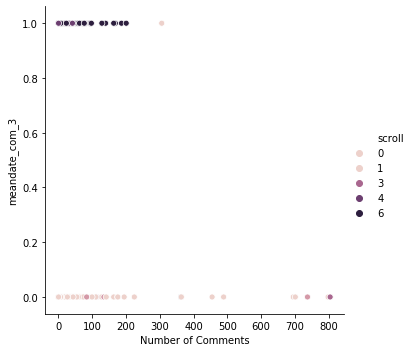

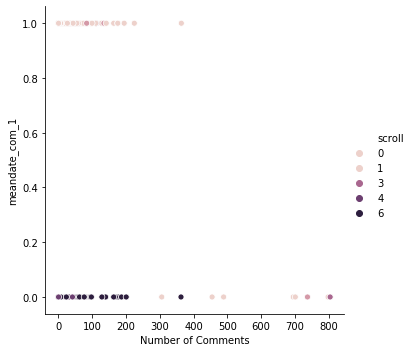

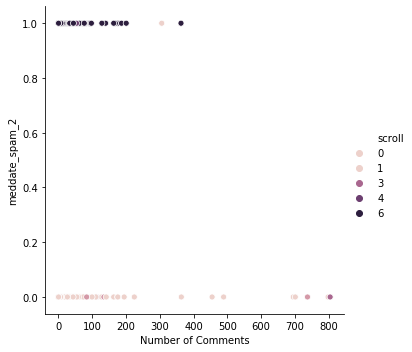

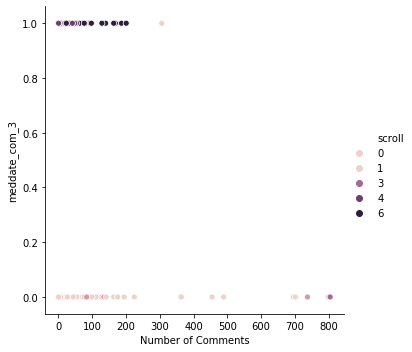

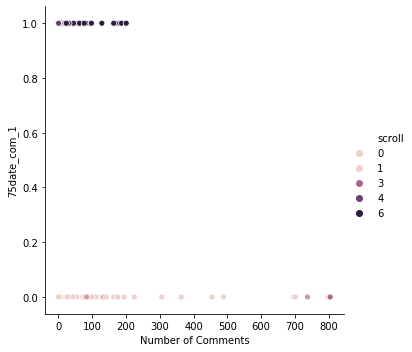

In [279]:
pl = ['meandate_com_3', 'meandate_com_1','meddate_spam_2','meddate_com_3','75date_com_1']
for i in pl:
    sns.relplot(y=i, x='Number of Comments',hue='scroll', data=spam_percent)

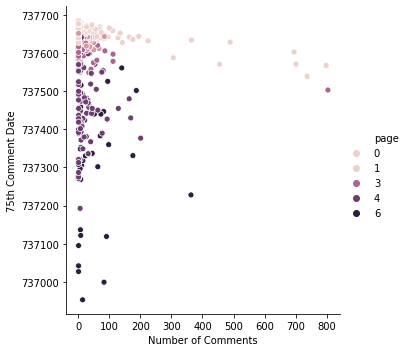

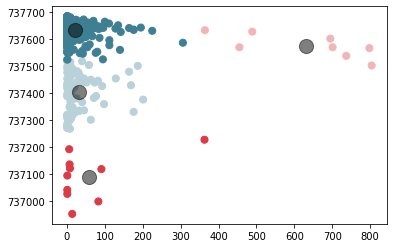

In [287]:
X = spam_percent[['75th Comment Date', 'Number of Comments']]
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)

sns.relplot(x='Number of Comments',y='75th Comment Date',hue='page', data=spam_percent)
plt.show()

plt.scatter(X.iloc[:, 1], X.iloc[:, 0], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

In [ ]:
sns.relplot(x='Number of Comments',y='Mean Comment Date',hue='page', data=spam_percent)


In [ ]:
sns.relplot(x='Median Comment Date', y='spam',hue='page', data=spam_percent)

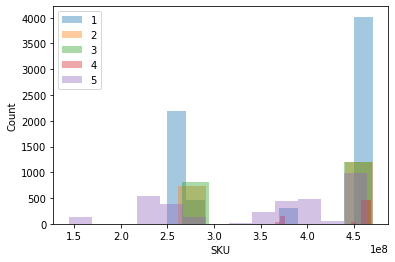

In [28]:
reviews_scroll = pd.merge(reviews_cleaned,spam_percent[['SKU','scroll']], on='SKU')
pg1 = reviews_scroll[reviews_scroll['scroll'] == 1]['SKU']
pg2 = reviews_scroll[reviews_scroll['scroll'] == 2]['SKU']
pg3 = reviews_scroll[reviews_scroll['scroll'] == 3]['SKU']
pg4 = reviews_scroll[reviews_scroll['scroll'] == 4]['SKU']
pg5 = reviews_scroll[reviews_scroll['scroll'] == 5]['SKU']
sns.distplot(pg1, kde=False)
sns.distplot(pg2, kde=False)
sns.distplot(pg3, kde=False)
sns.distplot(pg4, kde=False)
sns.distplot(pg5, kde=False)
plt.ylabel('Count')
plt.legend(labels=['1', '2','3','4','5'])


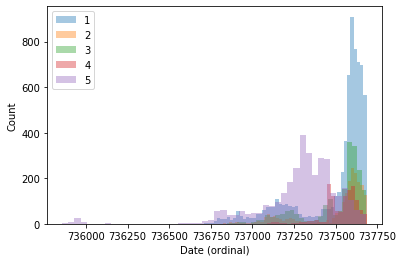

In [29]:
pg1 = reviews_scroll[reviews_scroll['scroll'] == 1]['Date (ordinal)']
pg2 = reviews_scroll[reviews_scroll['scroll'] == 2]['Date (ordinal)']
pg3 = reviews_scroll[reviews_scroll['scroll'] == 3]['Date (ordinal)']
pg4 = reviews_scroll[reviews_scroll['scroll'] == 4]['Date (ordinal)']
pg5 = reviews_scroll[reviews_scroll['scroll'] == 5]['Date (ordinal)']
sns.distplot(pg1, kde=False)
sns.distplot(pg2, kde=False)
sns.distplot(pg3, kde=False)
sns.distplot(pg4, kde=False)
sns.distplot(pg5, kde=False)
plt.ylabel('Count')
plt.legend(labels=['1', '2','3','4','5'])

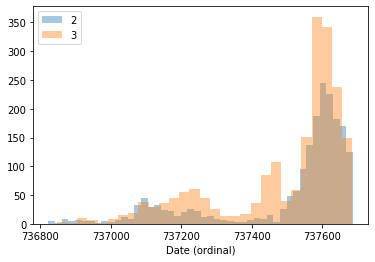

In [30]:
sns.distplot(pg2, kde=False)
sns.distplot(pg3, kde=False)
plt.legend(labels=['2','3'])

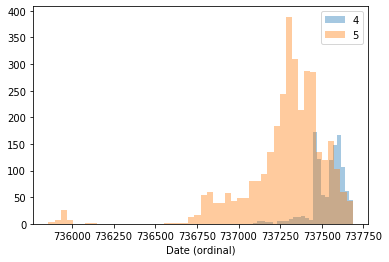

In [31]:
sns.distplot(pg4, kde=False)
sns.distplot(pg5, kde=False)
plt.legend(labels=['4','5'])

In [13]:
X = preprocessing.scale(items_train[top40])
Y = items_train['scroll']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) # 70% training and 30% test

lm = LogisticRegression(fit_intercept=True,C=1,penalty='l2',solver='lbfgs')
#lm = LogisticRegression(multi_class='multinomial',solver ='newton-cg').fit(X_train, y_train)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)
cv_scores_linreg = cross_val_score(lm,X_train,y_train,scoring='accuracy')

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(lm.score(X_test, y_test)))
print("Training R^2: {}".format(lm.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(y_test, np.round(y_pred)))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average='weighted'))

Testing R^2: 0.5412844036697247
Training R^2: 0.6692913385826772
Root Mean Squared Error: 1.0181833075170807
Mean Absolute Error: 0.6146788990825688
Mean 5-Fold CV Score: 0.5157647058823529
5-Fold CV Scores: [0.56862745 0.52941176 0.52941176 0.43137255 0.52      ]
              precision    recall  f1-score   support

           1       0.64      0.70      0.67        30
           2       0.33      0.35      0.34        17
           3       0.40      0.20      0.27        20
           4       0.43      0.43      0.43        23
           5       0.72      0.95      0.82        19

    accuracy                           0.54       109
   macro avg       0.50      0.53      0.51       109
weighted avg       0.52      0.54      0.52       109

Accuracy: 0.5412844036697247
Precision: 0.5177759243814289
Recall: 0.5412844036697247


In [17]:
X = preprocessing.scale(items_test[top40])
Y = items_test['scroll']

y_pred = lm.predict(X)
cv_scores_linreg = cross_val_score(lm,X,Y,scoring='accuracy')

# Model Accuracy, how often is the classifier correct?
print("Testing R^2: {}".format(lm.score(X, Y)))
print("Training R^2: {}".format(lm.score(X, Y)))
rmse = np.sqrt(mean_squared_error(Y, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
mae = mean_absolute_error(Y, y_pred)
print("Mean Absolute Error: {}".format(mae))
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
print("5-Fold CV Scores: {}".format(cv_scores_linreg))
print(classification_report(Y, np.round(y_pred)))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(Y, y_pred,average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(Y, y_pred,average='weighted'))

Testing R^2: 0.5164835164835165
Training R^2: 0.5164835164835165
Root Mean Squared Error: 1.0690449676496976
Mean Absolute Error: 0.7032967032967034
Mean 5-Fold CV Score: 0.5163742690058479
5-Fold CV Scores: [0.52631579 0.55555556 0.55555556 0.44444444 0.5       ]
              precision    recall  f1-score   support

           1       0.43      0.76      0.55        17
           2       0.27      0.18      0.21        17
           3       0.22      0.10      0.13        21
           4       0.55      0.67      0.60        18
           5       0.89      0.94      0.92        18

    accuracy                           0.52        91
   macro avg       0.47      0.53      0.48        91
weighted avg       0.47      0.52      0.47        91

Accuracy: 0.5164835164835165
Precision: 0.46805650489861017
Recall: 0.5164835164835165
